In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from scipy import interpolate
from time import sleep
from tqdm import tqdm
from numpy import linalg as LA

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [24]:
def ReadResponse(name):
  Response_set = []
  x = np.loadtxt(name,dtype='float32',skiprows=5,delimiter=",")
  t0_index = np.argmin(abs(x[:,0]-145e-6))
  t_end = np.argmin(abs(x[:,0]-300e-6))
  interpolator = interpolate.interp1d(x[t0_index:t_end,0], x[t0_index:t_end,1],kind='linear',fill_value=0,bounds_error=False)
  Interpolated_Response = interpolator(Time_response)
  Response_set.append(list(Interpolated_Response))
  return np.array(Response_set).reshape(-1,1)

def Cumulative(wave):
    cu_list = []
    lists = wave.tolist()[0]
    length = len(lists)
    lists = [i**2 for i in lists]
    cu_list = [sum(lists[0:x:1]) for x in range(0, length+1)]
    return np.array(cu_list[1:])

def FindValueIndex(seq, val):
    r = np.where(np.diff(np.sign(seq - val)) != 0)
    idx = r + (val - seq[r]) / (seq[r + np.ones_like(r)] - seq[r])
    idx = np.append(idx, np.where(seq == val))
    idx = np.sort(idx)
    return np.round(idx)

def FindTOF(wave):
  Ts = 2e-7
  Threshold = 0.25
  Cum_Amp_1 = Cumulative(wave)
  Cum_Amp_1_t = np.gradient(Cum_Amp_1,Ts*1e6)
  Target_Amp = np.max(Cum_Amp_1_t)*Threshold
  index = FindValueIndex(Cum_Amp_1_t,Target_Amp).astype(int)
  TOF = next(val for x, val in enumerate(Time_response[index]) if val > 145e-6)

  return TOF*1e6

def FindTOF_longwindow(wave):
  Ts = 2e-7
  Threshold = 0.25
  Long_response = np.arange(145e-6, 225e-6+Ts/2, Ts)
  Cum_Amp_1 = Cumulative(wave)
  Cum_Amp_1_t = np.gradient(Cum_Amp_1,Ts*1e6)
  Target_Amp = np.max(Cum_Amp_1_t)*Threshold
  index = FindValueIndex(Cum_Amp_1_t,Target_Amp).astype(int)
  TOF = next(val for x, val in enumerate(Long_response[index]) if val > 154e-6)
  return TOF*1e6

# GenerateSine(Peak-peak Amplitude,frequency,cycles)
def GenerateSine(A,freq,cycles):
  t = np.linspace(0, 50e-6, 251)
  Time = np.arange(0, cycles/freq/1e3, 2e-7)
  Amp = A / 2 * np.sin(2*np.pi*freq*1e3*Time)
  Amp = np.append(Amp,np.zeros(251-len(Time)))
  return Amp

def GenerateNoisySine(A,freq,cycles,sigma):
  t = np.linspace(0, 50e-6, 251)
  Time = np.arange(0, cycles/freq/1e3, 2e-7)
  Amp = A / 2 * np.sin(2*np.pi*freq*1e3*Time)
  noise_sigma = np.std(Amp)*sigma
  Amp = np.append(Amp,np.zeros(251-len(Time)))
  Amp = Amp + np.random.normal(0,noise_sigma,len(Amp))
  return Amp

# consider the specific heat ratio
def Cal_percentage(t_A,M_B,delta_t,gas):
    if gas == 'Air':
      k_B = 1.4 # air
    elif gas == 'Argon':
      k_B = 1.66 # argon
    M_A =  4.002602 #  Gas A: helium [g/mol]
    k_A = 1.66
    M_ratio = (M_B-M_A)/M_A
    t_ratio = (t_A/(t_A+delta_t))**2
    nume = k_A * (1-t_ratio)
    denu = t_ratio*k_A*M_ratio-k_B+k_A
    percentage = nume/denu # percentage (minus means delay)
    return percentage*100

def Cal_deltaTOF(con_argon,con_air):

    R = 8.314 # individual gas constant (J/mol*K)
    T = 292 # absolute temperature (K)
    L = 150 # [mm]
    t_A = L / np.sqrt(1.66*R*T/(4.002602/1e3)) * 1e3
    k_M = (1.66*(100-con_argon-con_air)+1.66*con_argon+1.4*con_air)/100
    M_M = (4.002602*(100-con_argon-con_air)+39.948*con_argon+28.966*con_air)/100/1e3 # kg/mol
    c_M = np.sqrt(k_M*R*T/M_M)
    return (L / c_M * 1e3-t_A)

def Cal_deltaTOF_T(con_argon,con_air,T_initial,T_impurity):

    R = 8.314 # individual gas constant (J/mol*K)
    L = 150 # [mm]
    t_A = L / np.sqrt(1.66*R*T_initial/(4.002602/1e3)) * 1e3
    k_M = (1.66*(100-con_argon-con_air)+1.66*con_argon+1.4*con_air)/100
    M_M = (4.002602*(100-con_argon-con_air)+39.948*con_argon+28.966*con_air)/100/1e3 # kg/mol
    c_M = np.sqrt(k_M*R*T_impurity/M_M)
    return (L / c_M * 1e3-t_A)

def CalVolume(array,time,gas):
    MFC_Helium = 0.1646 #(sl/s) / V
    MFC_Air = 118.56  #(sccm/s) / V

    interval = time / len(array)
    if gas == 'Helium':
        volume = np.trapz(array * MFC_Helium, dx=interval)
    elif gas == 'Air':
        volume = np.trapz(array * MFC_Air, dx=interval)
    return(volume)

In [4]:
Cal_deltaTOF_T(3,3,296,292)

32.362848649790806

# Data Pre-processing

Read Excitations

In [ ]:
Excitation_set = []

In [ ]:
Ts = 2e-7
Time_exci = np.arange(0, 50e-6+Ts/2, Ts)
Time_exci

In [ ]:
%cd /content/gdrive/MyDrive/AME508/Helium-Data/20221225_DigitalTwinData_and_Backfill_Air_NoPlates/Training/600khz
for n in range(223):
  x = np.loadtxt('C1--Trace-Helium-15cm--00'+str(f"{n:03}")+'.csv',dtype='float32',skiprows=5,delimiter=",")
  t0_index = np.argmin(abs(x[:,0]))
  t_end = np.argmin(abs(x[:,0]-50e-6))

  interpolator = interpolate.interp1d(x[t0_index:t_end,0], x[t0_index:t_end,1],kind='linear',fill_value=0,bounds_error=False)
  Interpolated_Excitation = interpolator(Time_exci)

  Excitation_set.append(list(Interpolated_Excitation))

/content/gdrive/MyDrive/AME508/Helium-Data/20221225_DigitalTwinData_and_Backfill_Air_NoPlates/Training/600khz


In [ ]:
Excitation_set = np.array(Excitation_set)

In [ ]:
np.save('Excitation_set.npy',Excitation_set)

1.0561709664125152


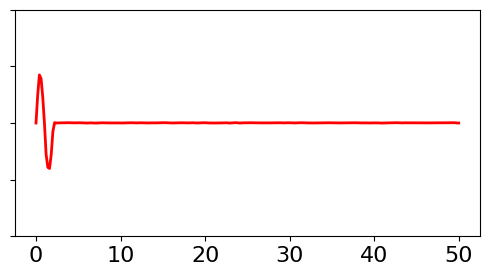

In [ ]:
from matplotlib import rcParams
plt.figure(figsize=(6,3),dpi=100)  # Figure size
mpl.rcParams.update({'font.size': 16})  # Global font size

idx = 183

plt.plot(Time_exci*1e6,Excitation_set[idx:idx+1,:-2].reshape(-1,1),linewidth=2,color='red')
#plt.plot(Time_exci*1e6,test.reshape(-1,1),linewidth=2,color='b')

#plt.xlabel ('Time / us'),plt.xlim(0,50)
#plt.ylabel ('Amplitude / V')
#plt.axis('off')
plt.ylim(-1,1)
plt.tick_params(labelleft=False)
print(np.max(Excitation_set[idx:idx+1,:])-np.min(Excitation_set[idx:idx+1,:]))

Read Responses

In [ ]:
Response_set = []

In [ ]:
Time_response = np.arange(145e-6, 215e-6+Ts/2, Ts)

Time_response

In [ ]:
%cd /content/gdrive/MyDrive/AME508/Helium-Data/20221225_DigitalTwinData_and_Backfill_Air_NoPlates/Training/600khz

for n in range(223):
  x = np.loadtxt('C2--Trace-Helium-15cm--00'+str(f"{n:03}")+'.csv',dtype='float32',skiprows=5,delimiter=",")

  t0_index = np.argmin(abs(x[:,0]-145e-6))
  t_end = np.argmin(abs(x[:,0]-300e-6))

  interpolator = interpolate.interp1d(x[t0_index:t_end,0], x[t0_index:t_end,1],kind='linear',fill_value=0,bounds_error=False)
  Interpolated_Response = interpolator(Time_response)

  Response_set.append(list(Interpolated_Response))

/content/gdrive/MyDrive/AME508/Helium-Data/20221225_DigitalTwinData_and_Backfill_Air_NoPlates/Training/600khz


In [ ]:
Response_set = np.array(Response_set)

In [ ]:
np.save('Response_set.npy',Response_set)

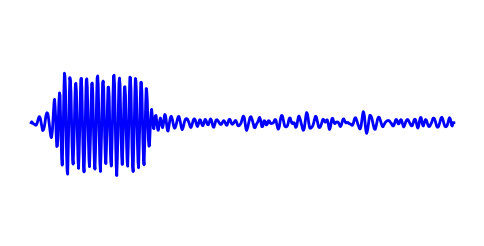

In [ ]:
plt.figure(figsize=(6,3),dpi=100)  # Figure size
mpl.rcParams.update({'font.size': 16})  # Global font size

plt.plot(Time_response*1e6,Response_set[idx:idx+1,:].reshape(-1,1),linewidth=2,color='b')
#plt.xlabel ('Time / us'),plt.xlim(145,300)
#plt.ylabel ('Amplitude / V')
plt.axis('off')

plt.ylim(-1,1)
plt.tick_params(labelleft=False)

# Load Pre-processed Data (Please RUN FROM HERE)

In [5]:
%cd /content/gdrive/MyDrive/AME508/Helium-Data/20230113_TwoImpurityTEST_WithoutPlates

/content/gdrive/MyDrive/AME508/Helium-Data/20230113_TwoImpurityTEST_WithoutPlates


In [6]:
Excitation_set = np.load('Input_set.npy') # 2351 is the # of samples, 251 is the length
Response_set = np.load('Response_set.npy') # 351 is the length

Ts = 2e-7 # sampling interval
Time_exci = np.arange(0, 50e-6+Ts/2, Ts)
Time_response = np.arange(145e-6, 300e-6+Ts/2, Ts)

In [7]:
# REMOVE <100mVpp
idx_to_delet = np.argwhere(np.ptp(Excitation_set[:,:-2], axis=1) < 0.1)
Excitation_set = np.delete(Excitation_set,idx_to_delet,axis=0)
Response_set = np.delete(Response_set,idx_to_delet,axis=0)

In [8]:
# REMOVE those random shift by equipment
idx_to_delet = np.argwhere(Excitation_set[:,0]>0.1)
Excitation_set = np.delete(Excitation_set,idx_to_delet,axis=0)
Response_set = np.delete(Response_set,idx_to_delet,axis=0)

In [9]:
X = np.column_stack((Excitation_set,Response_set))

Excitation_train, Excitation_test, Response_train, Response_test = train_test_split(X[:,:253], X[:,253:], test_size = 0.3,random_state=42)
#Excitation_vali, Excitation_test, Response_vali, Response_test = train_test_split(Excitation_test, Response_test, test_size = 0.5,random_state=42)

train_branch_input = Excitation_train

train_ground_truth = Response_train

X_train = np.column_stack((train_branch_input,train_ground_truth))

np.shape(X_train)

(68831, 1029)

# Create custom dataset class

In [10]:
class DataSet(torch.utils.data.Dataset):
  def __init__(self, ds):
    self.data = ds

  def __len__(self):
    return len(self.data[:,:])

  def __getitem__(self, idx):
    data = self.data[idx]
    return data

# Create dataset generator

In [11]:
# Generators
trainingData = DataSet(X_train)
training_generator = torch.utils.data.DataLoader(trainingData,batch_size=5000,shuffle=True)

# Build and Train Neural Network

In [15]:
class NN(torch.nn.Module):
  def __init__(self, input_dim, output_dim):
    super(NN, self).__init__()

    #self.act = nn.Tanh()
    self.act = Sine()

    self.model = nn.ModuleList() # use containers by nn.ModuleList
    self.model.append(nn.Linear(input_dim, 300)) # input layer to 1st hidden layer
    self.model.append(nn.Linear(300, 350))
    self.model.append(nn.Linear(350, 400))
    self.model.append(nn.Linear(400, 450))
    self.model.append(nn.Linear(450, 500))
    self.model.append(nn.Linear(500, 550))
    self.model.append(nn.Linear(550, 600))
    self.model.append(nn.Linear(600, 650))
    self.model.append(nn.Linear(650, 700))
    self.model.append(nn.Linear(700, 750))

    self.model.append(nn.Linear(750, output_dim)) # last hidden layer to output layer
    self.depth = len(self.model)

  def forward(self, x):
    for idx, layer in enumerate(self.model):
      # only apply affine trans for the last layer
      if idx == self.depth-1:
        x = layer(x)
      # otherwise, apply affine and activation function
      else:
        x = self.act(layer(x)) # apply activation
    return x

# Define sine activation function
class Sine(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, input):
    return torch.sin(input)

In [13]:
class NN(torch.nn.Module):
  def __init__(self, input_dim, output_dim, width, depth):
    super(NN, self).__init__()
    self.depth = depth
    #self.act = nn.Tanh()
    self.act = Sine()

    self.model = nn.ModuleList() # use containers by nn.ModuleList
    self.model.append(nn.Linear(input_dim, width)) # input layer to 1st hidden layer

    for i in range(1,depth-1):
      self.model.append(nn.Linear(width, width)) # hidden layers
    self.model.append(nn.Linear(width, output_dim)) # last hidden layer to output layer

  def forward(self, x):
    for idx, layer in enumerate(self.model):
      # only apply affine trans for the last layer
      if idx == self.depth-1:
        x = layer(x)
      # otherwise, apply affine and activation function
      else:
        x = self.act(layer(x)) # apply activation
    return x

# Define sine activation function
class Sine(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, input):
    return torch.sin(input)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# create the model
#branch_net = NN(253, 776, 600, 8).to(device)
branch_net = NN(253, 776).to(device)

torch.set_printoptions(precision=20)

loss_fn = nn.MSELoss()
max_epochs = 5000

optimizer = optim.AdamW(branch_net.parameters(), lr=1e-4, betas=(0.9, 0.999),weight_decay=1e-7)

train_loss = []
vali_loss = []
test_loss = []

#inputs_vali = torch.from_numpy(Excitation_vali).to(torch.float32).to(device)
#groundtruth_vali = torch.from_numpy(Response_vali).to(torch.float32).to(device)

inputs_test = torch.from_numpy(Excitation_test).to(torch.float32).to(device)
groundtruth_test = torch.from_numpy(Response_test).to(torch.float32).to(device)

for epoch in tqdm(range(max_epochs)):
  for index, data in enumerate(training_generator):

    inputs_train = data[:,:253].to(torch.float32).to(device)
    groundtruth_train = data[:,253:].to(torch.float32).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # make prediction and evaluate loss
    prediction = branch_net(inputs_train)

    # evaluate loss
    tran_loss = loss_fn(prediction, groundtruth_train)

    # find the gradients using back-propagation
    tran_loss.backward()

    # update the weights
    optimizer.step()

  train_loss.append(tran_loss.item())

  # validation
  #vali_loss_i = loss_fn(branch_net(inputs_vali), groundtruth_vali).cpu().detach().numpy()
  #vali_loss_i = vali_loss_i.tolist()
  #vali_loss.append(vali_loss_i)

  # testing
  test_loss_i = loss_fn(branch_net(inputs_test), groundtruth_test).cpu().detach().numpy()
  test_loss_i = test_loss_i.tolist()
  test_loss.append(test_loss_i)

  sleep(0)

cuda:0


100%|██████████| 5000/5000 [58:34<00:00,  1.42it/s]


In [ ]:
PATH = './TrainedNet-dataClean.pth'
torch.save(branch_net.state_dict(), PATH)

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

PATH = './TrainedNet-dataClean.pth'

# create the model
branch_net = NN(253, 776).to(device)

branch_net.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))

cpu


<All keys matched successfully>

# Visualization

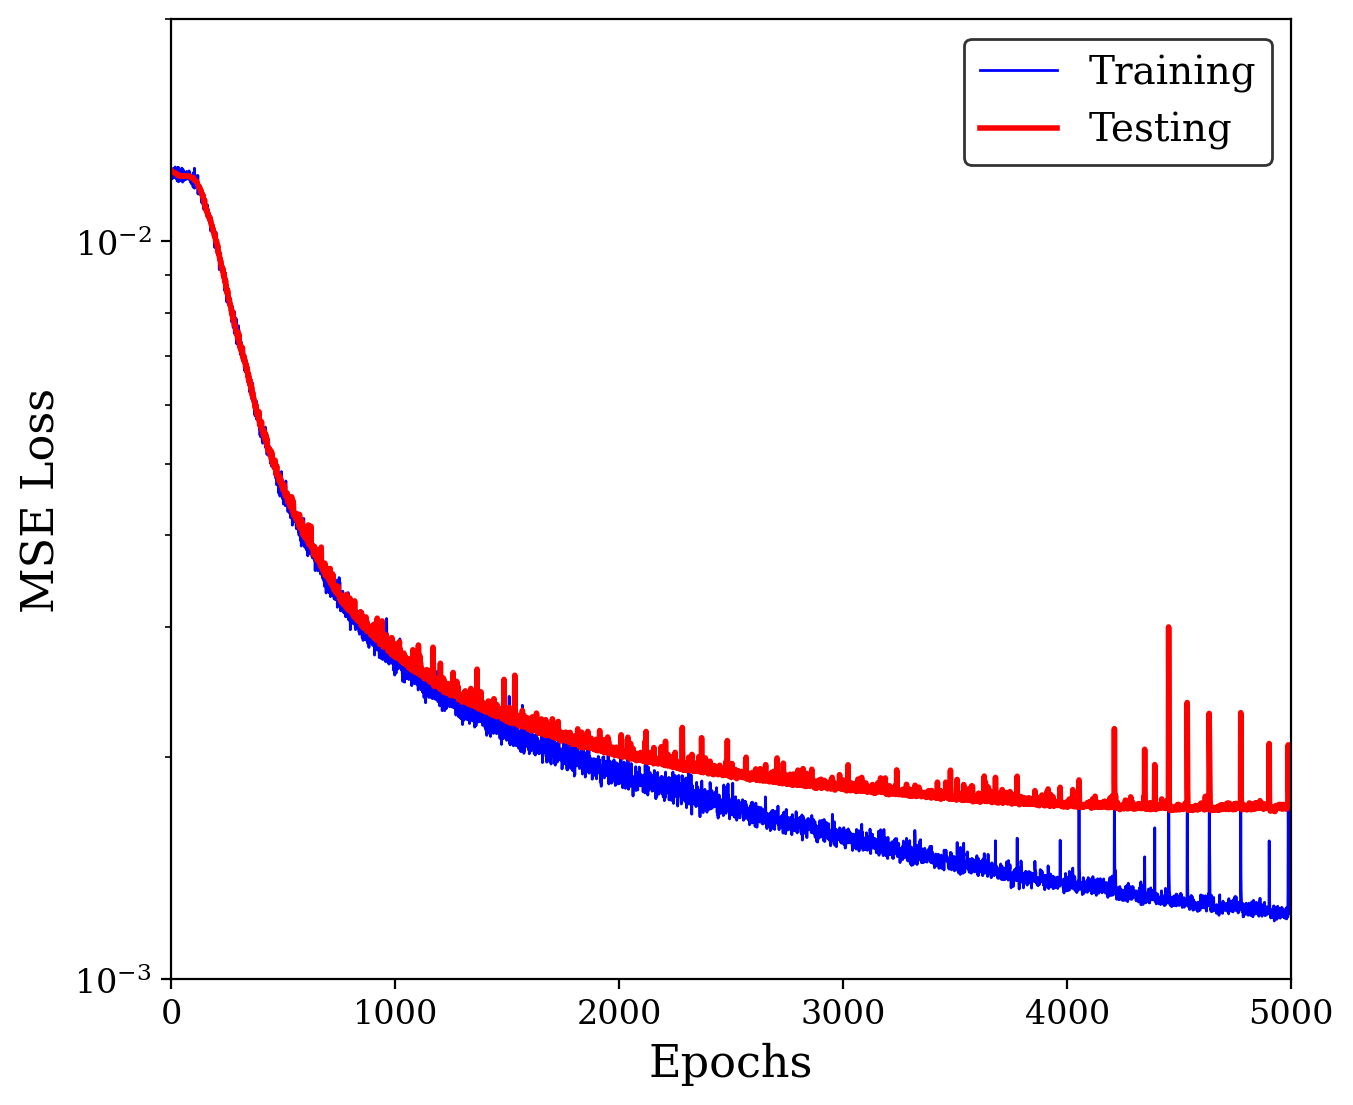

In [ ]:
nc = 1; nr = 1;
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('font',**{'family':'serif','serif':['Times']})
fig, ax  = plt.subplots(nr,nc,figsize=(7*nc,6*nr),dpi=200)
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.2,hspace=0.5)

epoNum = np.arange(1,max_epochs+1)
plt.plot(epoNum,train_loss,'-b',linewidth = 1,label='Training')
#plt.plot(epoNum,vali_loss,'-k',linewidth = 2,label='Validation')
plt.plot(epoNum,test_loss,'-r',linewidth = 2,label='Testing')

ax.legend(loc='upper right',edgecolor='k',fontsize=14,frameon=True,ncol=1)
ax.set_xlabel('Epochs',fontsize=16)
ax.set_ylabel('MSE Loss',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlim([0, max_epochs])
ax.set_ylim([1e-3, 2e-2])
plt.yscale('log')
plt.rcdefaults()

In [ ]:
# plot the output vs ground truth

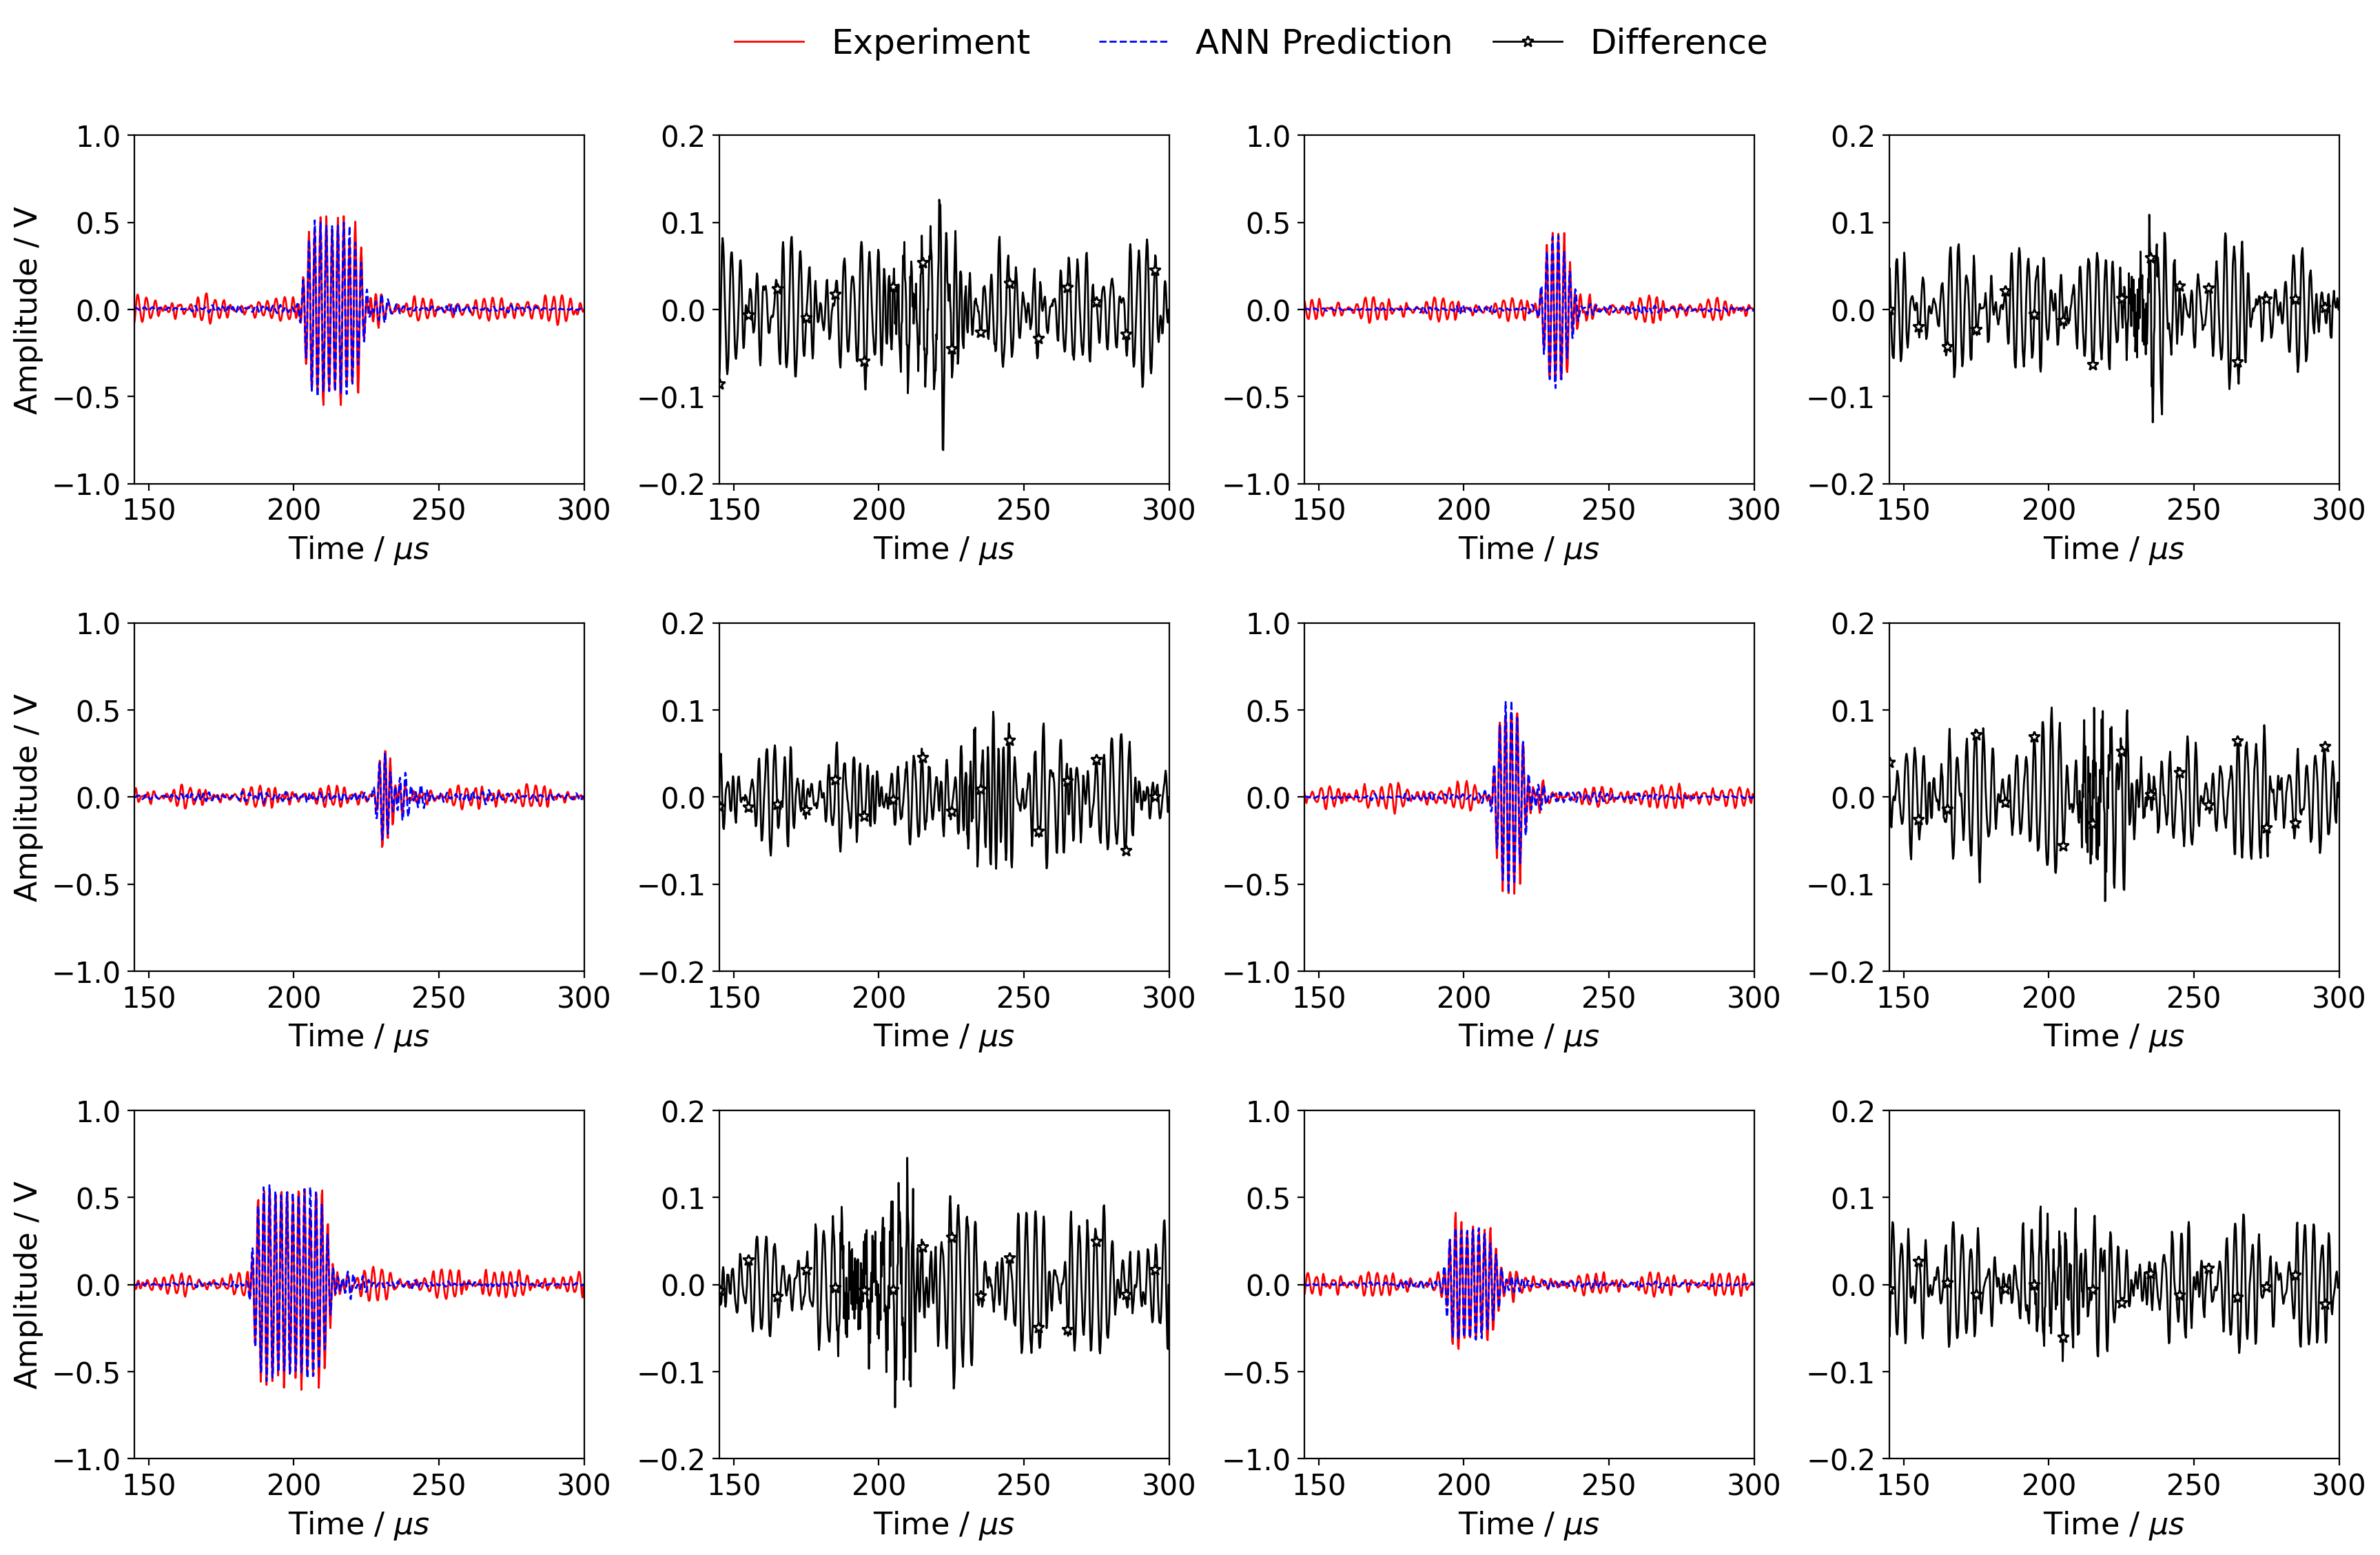

In [ ]:
Wave_idx = np.random.randint(Excitation_test.shape[0])
nr = 3
nc = 4

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('font',**{'family':'serif','serif':['Times']})
fig, ax  = plt.subplots(nr,nc,figsize=(5*nc,4*nr),dpi=200)
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.3,hspace=0.4)
ax = ax.flatten()

for idx in range(nr*nc):
  if idx%2 == 0:
    with torch.no_grad():
      test_inputs_branch = torch.from_numpy(Excitation_test[Wave_idx:Wave_idx+1,:]).to(torch.float32).to(device)
      test_prediction = branch_net(test_inputs_branch).cpu().detach().numpy()

    ax[idx].plot(Time_response*1e6,Response_test[Wave_idx:Wave_idx+1,:].reshape(-1,1),'r',linewidth = 1,label='Experiment')
    ax[idx].plot(Time_response*1e6,test_prediction.reshape(-1,1),'--b',linewidth = 1,label='ANN Prediction')
    ax[idx].set_xlabel('Time / $\mu s$',fontsize=16);ax[idx].set_xlim(145,300);ax[idx].set_ylim(-1,1)
    ax[nr*nc-2].legend(bbox_to_anchor=(0.4, 4.2),edgecolor='k',fontsize=18,frameon=False,ncol=2)
    if idx%4 == 0:
      ax[idx].set_ylabel('Amplitude / V',fontsize=16)

  else:
    Difference = Response_test[Wave_idx:Wave_idx+1,:].reshape(-1,1)-test_prediction.reshape(-1,1)
    ax[idx].plot(Time_response*1e6,Difference,'-*k',markevery=50,markerfacecolor='w',linewidth = 1,label='Difference')
    ax[idx].set_xlabel('Time / $\mu s$',fontsize=16);ax[idx].set_xlim(145,300);ax[idx].set_ylim(-0.2,0.2)
    #ax[idx].legend(loc='lower right',edgecolor='k',fontsize=14,frameon=True,ncol=1)
    Wave_idx += 1

plt.legend(bbox_to_anchor=(-0.2, 4.2),edgecolor='k',fontsize=18,frameon=False,ncol=1)

(-1.0, 1.0)

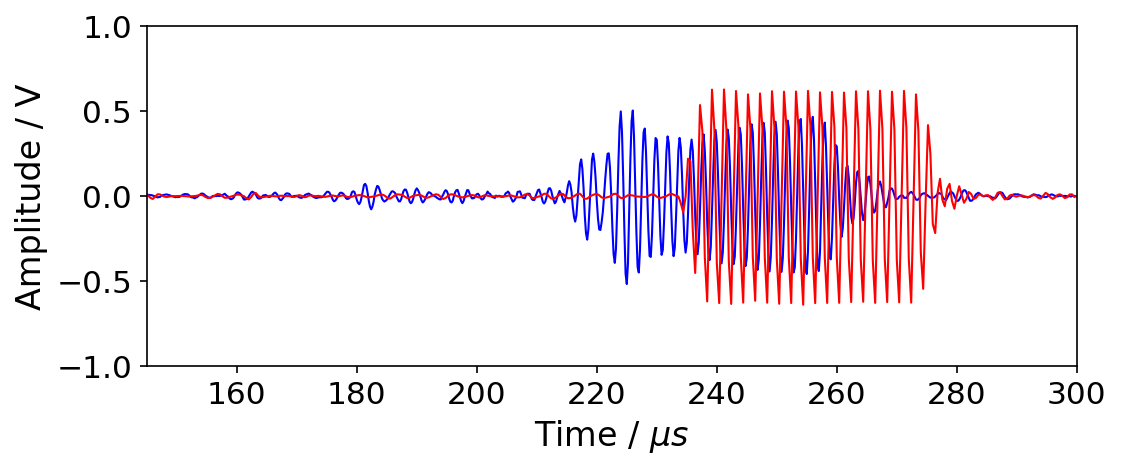

In [ ]:
plt.figure(figsize=(8,3),dpi=150)  # Figure size
mpl.rcParams.update({'font.size': 18})  # Global font size
mpl.rc('font',family='Times New Roman') # Global font style

input = np.append(GenerateSine(0.8,500,20),[5,8])
test = torch.from_numpy(input).to(torch.float32).to(device)
test_pred = branch_net(test).cpu().detach().numpy()

Test = ReadResponse('1000mV-20cycle-6.795Argon+9.883Air-Averaged30.csv')

plt.plot(Time_response*1e6,test_pred,linewidth =1,color='blue',label='Fitted Line')
plt.plot(Time_response*1e6,Test,color='red',linewidth =1,label='ANN Prediction')

plt.ylabel('Amplitude / V',fontsize=16);plt.xlabel('Time / $\mu s$',fontsize=16);plt.xlim(145,300);plt.ylim(-1,1)

# Determine TOF

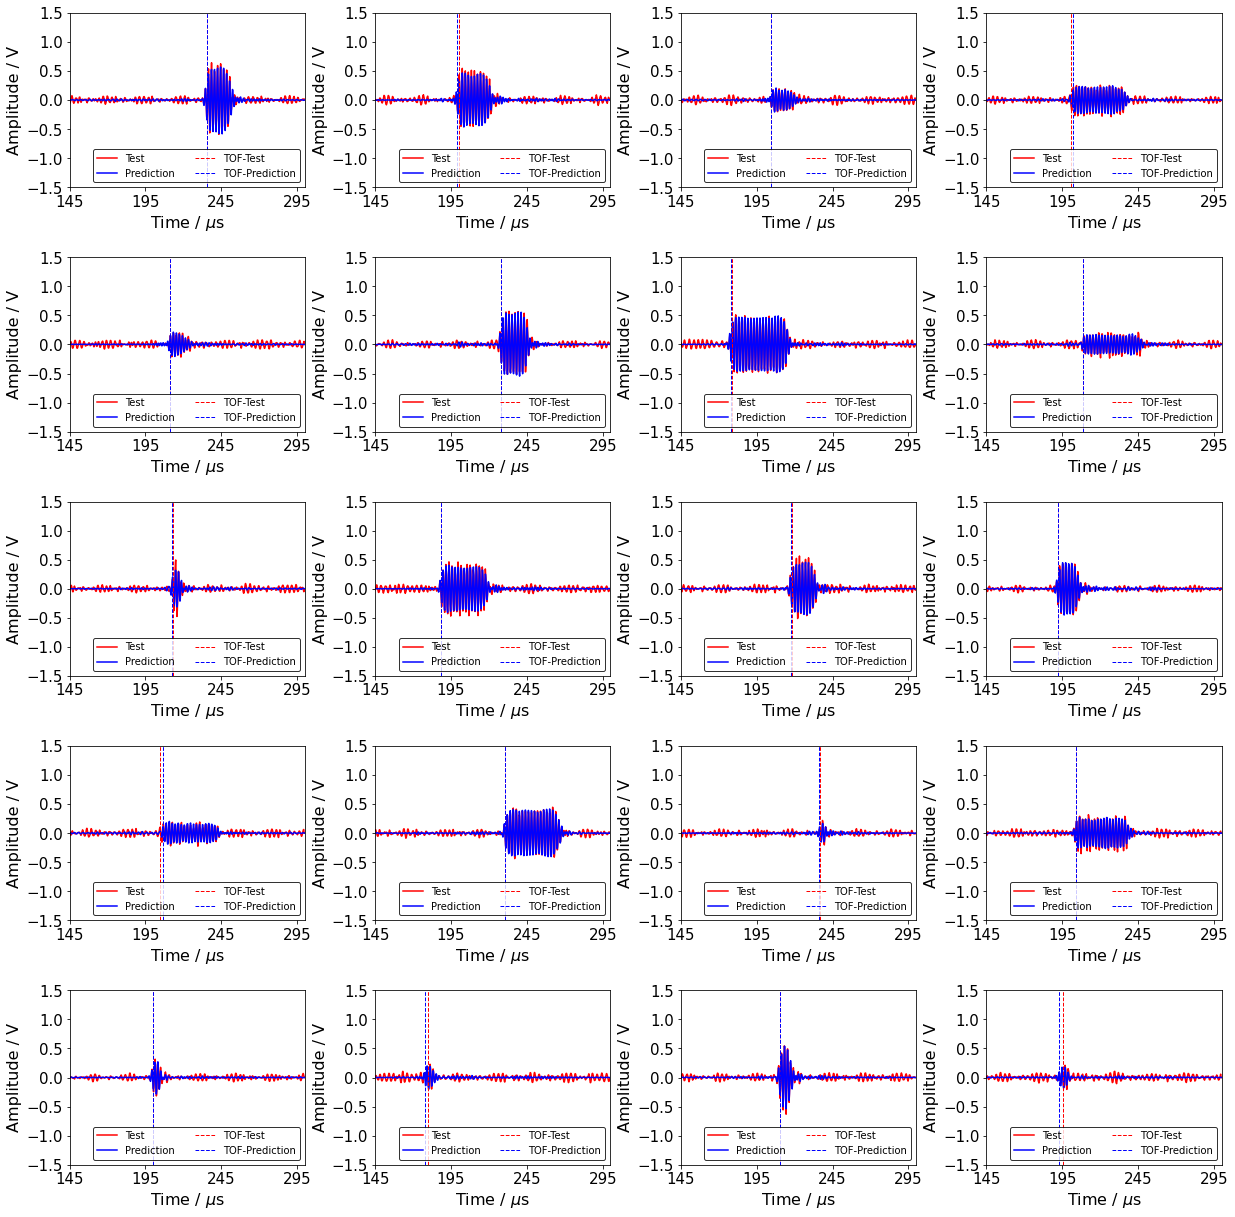

In [ ]:
Wave_idx = np.random.randint(Excitation_test.shape[0])
nr = 5
nc = 4

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('font',**{'family':'serif','serif':['Times']})
fig, ax  = plt.subplots(nr,nc,figsize=(5*nc,4*nr))
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.3,hspace=0.4)
ax = ax.flatten()

for idx in range(nr*nc):

  with torch.no_grad():
    test_inputs_branch = torch.from_numpy(Excitation_test[Wave_idx:Wave_idx+1,:]).to(torch.float32).to(device)
    test_prediction = branch_net(test_inputs_branch).cpu().detach().numpy()

  TOF_truth = FindTOF(Response_test[Wave_idx:Wave_idx+1,:])
  TOF_pre = FindTOF(test_prediction)

  ax[idx].plot(Time_response*1e6,Response_test[Wave_idx:Wave_idx+1,:].reshape(-1,1),'-r',linewidth = 1.5,label='Test')
  ax[idx].plot(Time_response*1e6,test_prediction.reshape(-1,1),'-b',linewidth = 1.5,label='Prediction')
  ax[idx].set_ylabel('Amplitude / V',fontsize=16);ax[idx].set_xlabel(u'Time / $\it{\u03bc}$s',fontsize=16);ax[idx].set_xlim(145,300);ax[idx].set_ylim(-1.5,1.5)
  ax[idx].set_xticks(np.arange(Time_response[0]*1e6, Time_response[-1]*1e6, 50))
  ax[idx].set_yticks(np.arange(-1.5, 2, .5))
  ax[idx].axvline(TOF_truth,color='r',linewidth=1,linestyle = '--',label = 'TOF-Test')
  ax[idx].axvline(TOF_pre,color='b',linewidth=1,linestyle = '--',label = 'TOF-Prediction')
  ax[idx].legend(loc='lower right',edgecolor='k',fontsize=10,frameon=True,ncol=2)
  Wave_idx += 1

In [17]:
TOF_truth = np.zeros(0,)
TOF_pre = np.zeros(0,)

for i in range(len(Excitation_test)):

  with torch.no_grad():
    test_inputs_branch = torch.from_numpy(Excitation_test[i:i+1,:]).to(torch.float32).to(device)
    test_prediction = branch_net(test_inputs_branch).cpu().detach().numpy()

    TOF_truth = np.append(TOF_truth,FindTOF(Response_test[i:i+1,:]))
    TOF_pre = np.append(TOF_pre,FindTOF(test_prediction))

In [18]:
(np.abs(TOF_truth - TOF_pre) < 2).sum() / len(Excitation_test) # comparison

0.9627796610169491

Text(0, 0.5, 'Predicted TOF / $\\mu s$')

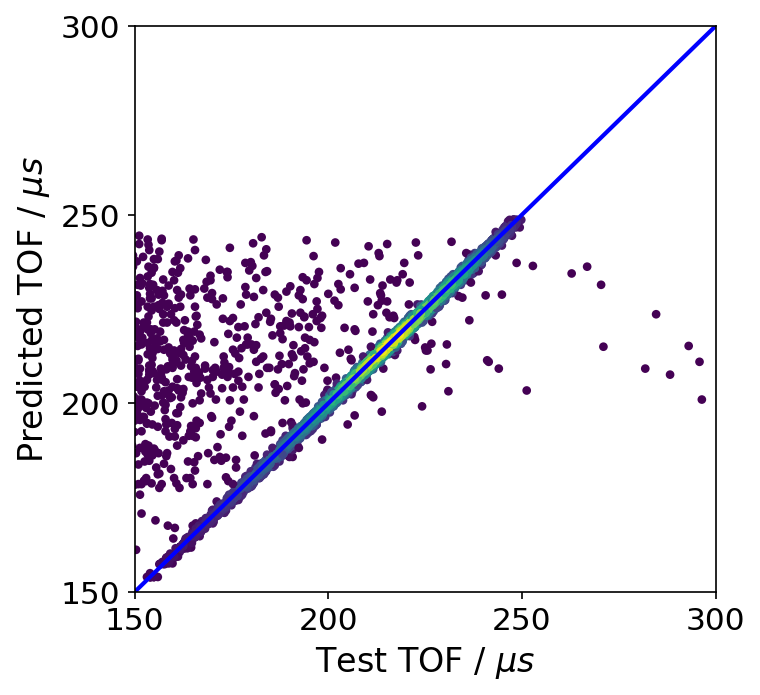

In [ ]:
from scipy.stats import gaussian_kde

plt.figure(figsize=(5,5),dpi=150)  # Figure size
mpl.rcParams.update({'font.size': 18})  # Global font size
mpl.rc('font',family='Times New Roman') # Global font style

xy = np.vstack([TOF_truth,TOF_pre])
z = gaussian_kde(xy)(xy)

plt.plot([0,300],[0,300],color = 'b',linewidth = 2,zorder=1)
#plt.plot([0,300],[-2,298],color = 'k',linewidth = 1,zorder=1)
#plt.plot([0,300],[2,302],color = 'k',linewidth = 1,zorder=1)
plt.scatter(TOF_truth,TOF_pre,c=z,s=10,label='True Response')

#plt.fill_between([0,300], [-2,298], [2,302], facecolor="r", alpha=0.5)
plt.xlim(150,300)
plt.ylim(150,300)
plt.xticks(np.arange(150, 350, 50))
plt.yticks(np.arange(150, 350, 50))
plt.xlabel('Test TOF / $\mu s$',fontsize=16)
plt.ylabel('Predicted TOF / $\mu s$',fontsize=16)

In [ ]:
energy_pre = np.zeros(0,)
energy_true = np.zeros(0,)
wave_pre = np.zeros((1,776))

for i in range(len(Excitation_test)):
  with torch.no_grad():
    test_inputs_branch = torch.from_numpy(Excitation_test[i:i+1,:]).to(torch.float32).to(device)
    test_prediction = branch_net(test_inputs_branch).cpu().detach().numpy()
    wave_pre = np.append(wave_pre, test_prediction,axis=0)
wave_pre = np.delete(wave_pre,0,0)

In [ ]:
sigma = 5
diff = wave_pre - Response_test
kernel = np.exp(- (LA.norm(diff,axis=1))**2 / 2 / sigma**2)

In [ ]:
(kernel > 0.95).sum() / len(Excitation_test) # comparison

0.9797288135593221

In [ ]:
diff = wave_pre - Response_test
MSE_test = (LA.norm(diff,axis=1))**2/776
print(np.where(MSE_test<0.01)[0].shape[0] / 29500)
print(np.mean(MSE_test))
print(np.std(MSE_test))

0.9916271186440678
0.0017275644450944138
0.005336010100675284


(0.0, 150.0)

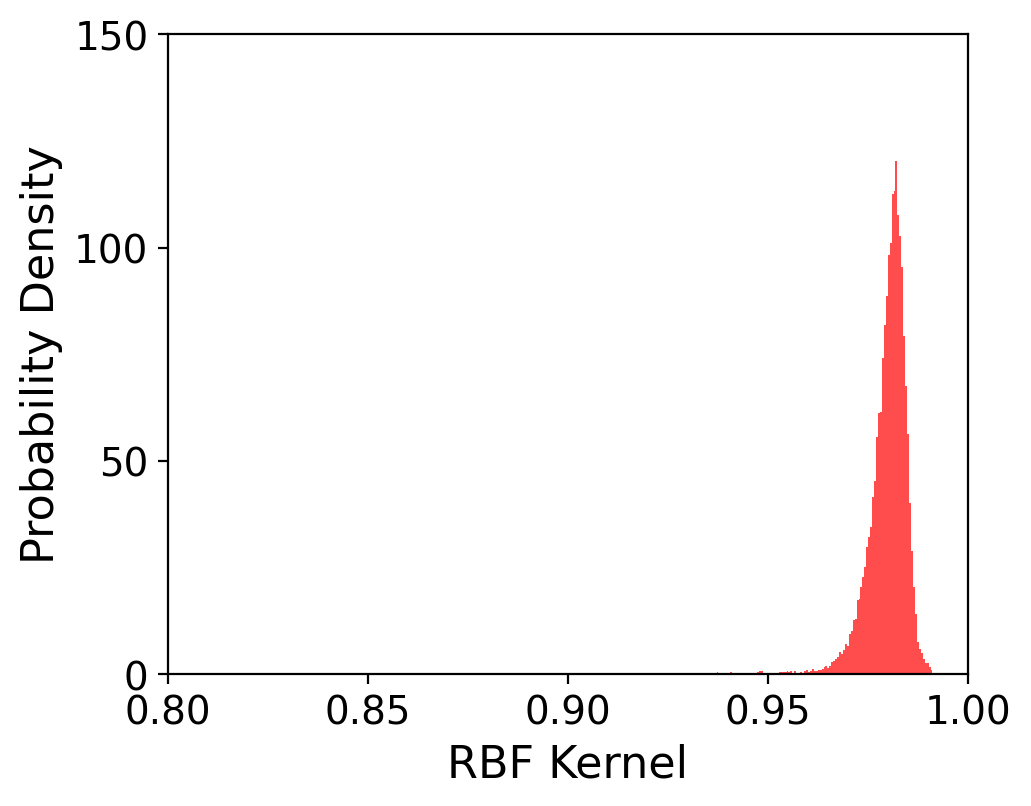

In [ ]:
from scipy.stats import norm

nr = 1
nc = 1

plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('font',**{'family':'serif','serif':['Times']})
fig, ax  = plt.subplots(nr,nc,figsize=(5*nc,4*nr),dpi=200)
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.2,hspace=0.4)
kwargs = dict(alpha=0.7, bins=2000)

#mu, std = norm.fit(kernel)
#x = np.linspace(0.95,1, 100)
#p = norm.pdf(x, mu, std)
#ax.plot(x, p, 'b', linewidth=2,label='Fitted Gaussain')

ax.hist(kernel, **kwargs,color = 'r',density=True)
#ax.hist(MSE_test, **kwargs,color = 'r',density=True)
ax.set_xlim(0.8,1)
#ax.set_xticks(np.arange(0,1, 0.002))
ax.set_yticks(np.arange(0,200, 50))
ax.set_ylabel('Probability Density', fontsize=16)
ax.set_xlabel('RBF Kernel', fontsize=16)
ax.set_ylim(0,150)
#ax.axvline(np.mean(MSE_test),color='b',linewidth=1,linestyle = '--',label = 'Mean Value')
#ax.legend(loc='upper right',edgecolor='k',fontsize=14,frameon=True,ncol=1)

In [ ]:
diff = wave_pre - Response_test
LA.norm(diff)
difference_mean = np.mean(diff,axis=1)
difference_std = np.std(diff,axis=1)

In [ ]:
np.std(difference_std)

0.017572628606827356

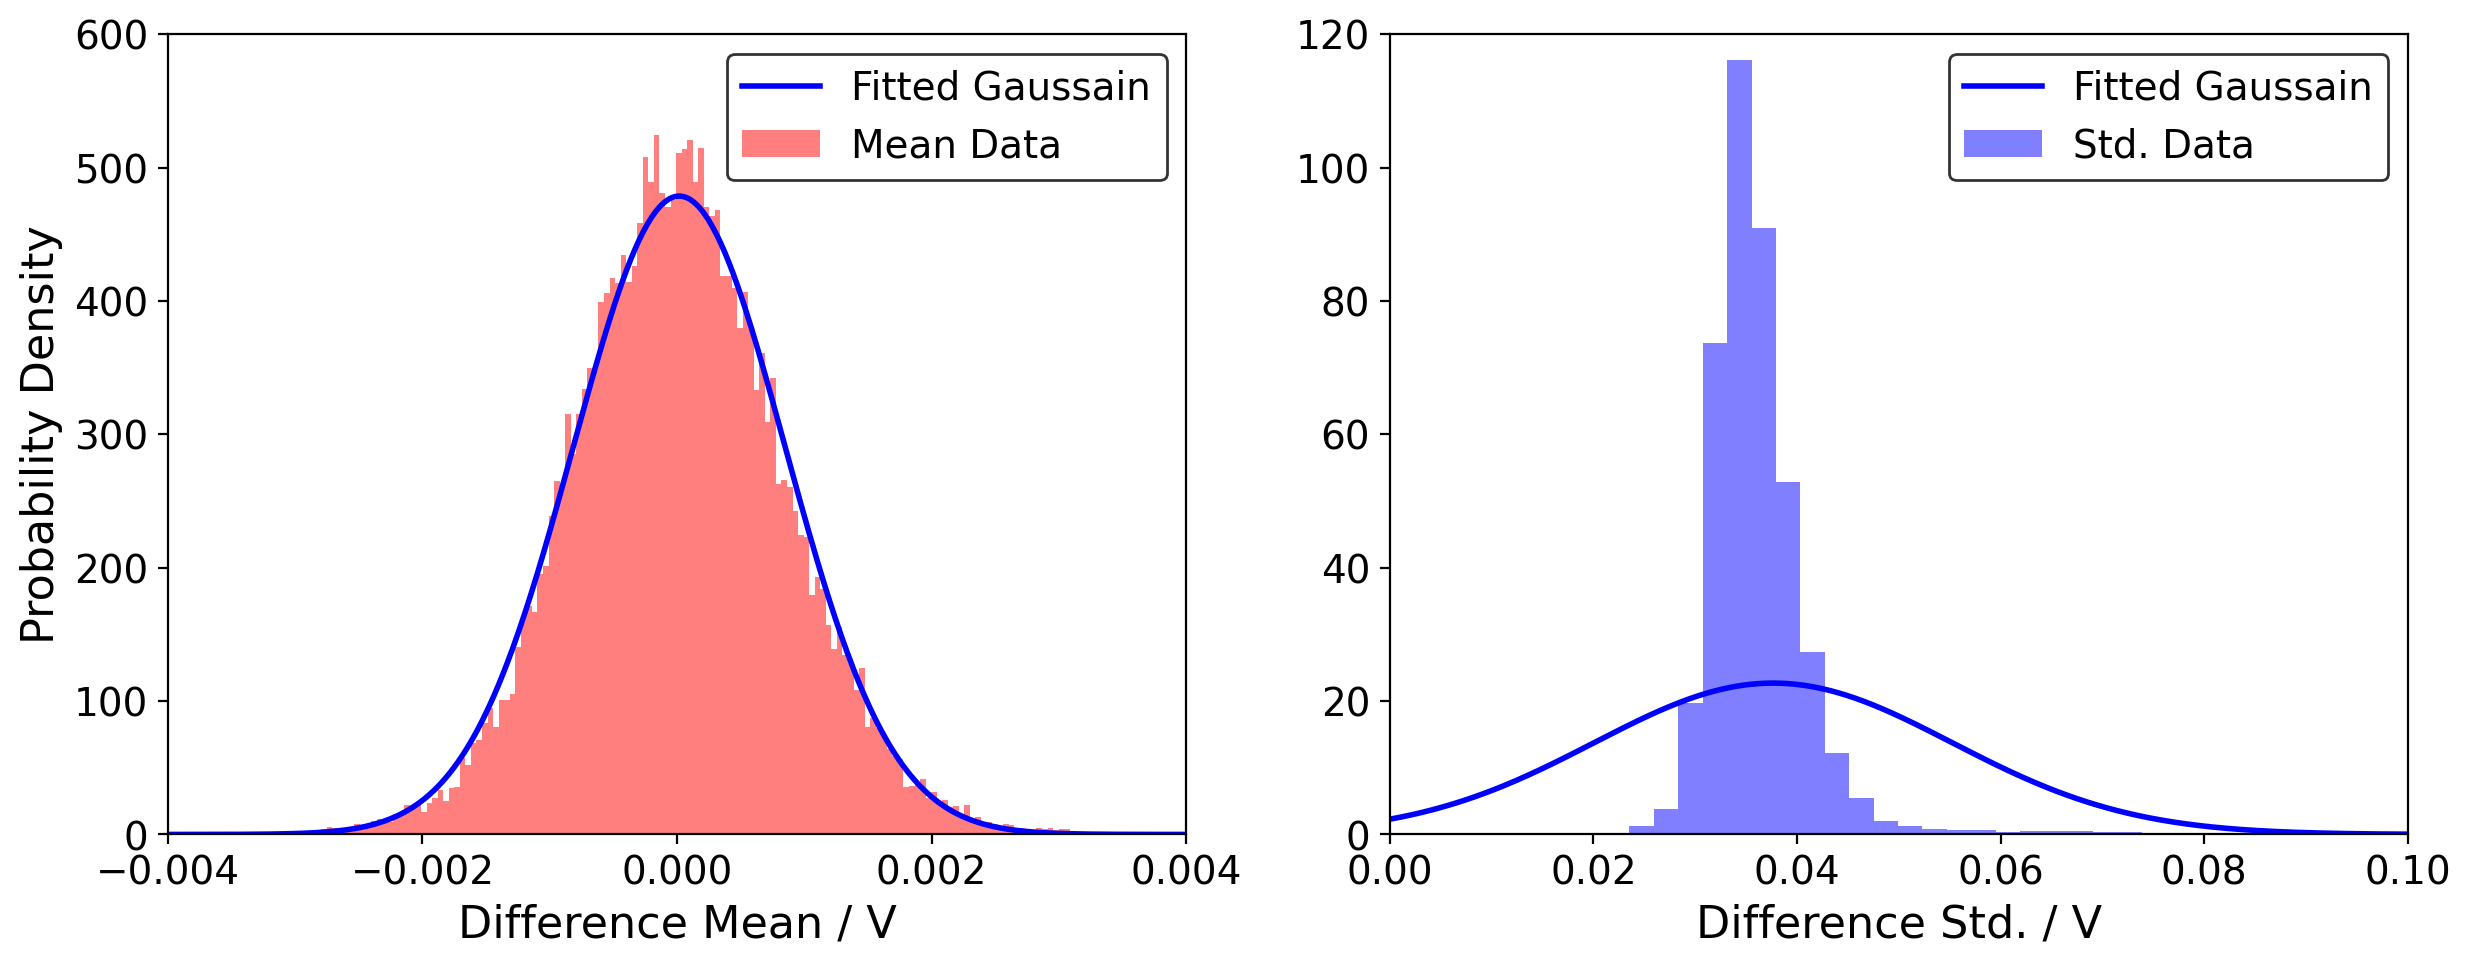

In [ ]:
from scipy.stats import norm

nr = 1
nc = 2

plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('font',**{'family':'serif','serif':['Times']})
fig, ax  = plt.subplots(nr,nc,figsize=(7*nc,5*nr),dpi=200)
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.2,hspace=0.4)
ax = ax.flatten()
kwargs = dict(alpha=0.5, bins=200)

for idx in range(nr*nc):
  if idx == 0:
    mu, std = norm.fit(difference_mean)
    x = np.linspace(-0.004,0.004, 500)
    p = norm.pdf(x, mu, std)
    ax[idx].plot(x, p, 'b', linewidth=2,label='Fitted Gaussain')

    ax[idx].hist(difference_mean, **kwargs,color = 'r',label='Mean Data',density=True)
    ax[idx].set_xlim(-0.004,0.004)
    ax[idx].set_xticks(np.arange(-0.004,0.006, 0.002))
    ax[idx].set_ylabel('Probability Density', fontsize=16)
    ax[idx].set_xlabel('Difference Mean / V', fontsize=16)
    ax[idx].set_ylim(0,600)

  else:
    ax[idx].hist(difference_std, **kwargs,color = 'b',label='Std. Data',density=True)

    mu_1, std_1 = norm.fit(difference_std)
    x_1 = np.linspace(0,0.1,500)
    p_1 = norm.pdf(x_1, mu_1, std_1)
    ax[idx].plot(x_1, p_1, 'b', linewidth=2,label='Fitted Gaussain')

    ax[idx].set_xlim(0,0.1)
    ax[idx].set_xlabel('Difference Std. / V', fontsize=16)
    ax[idx].set_ylim(0,120)

  ax[idx].legend(loc='upper right',edgecolor='k',fontsize=14,frameon=True,ncol=1)

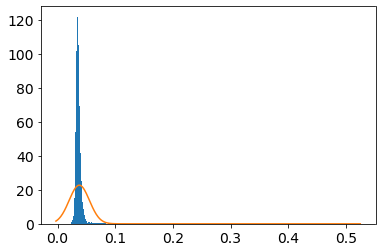

In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

data = difference_std
mean,std=norm.fit(data)

plt.hist(data, bins=500, density=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 500)
y = norm.pdf(x, mean, std)
plt.plot(x, y)
plt.show()

Text(0, 0.5, 'Predicted TOF / $\\mu s$')

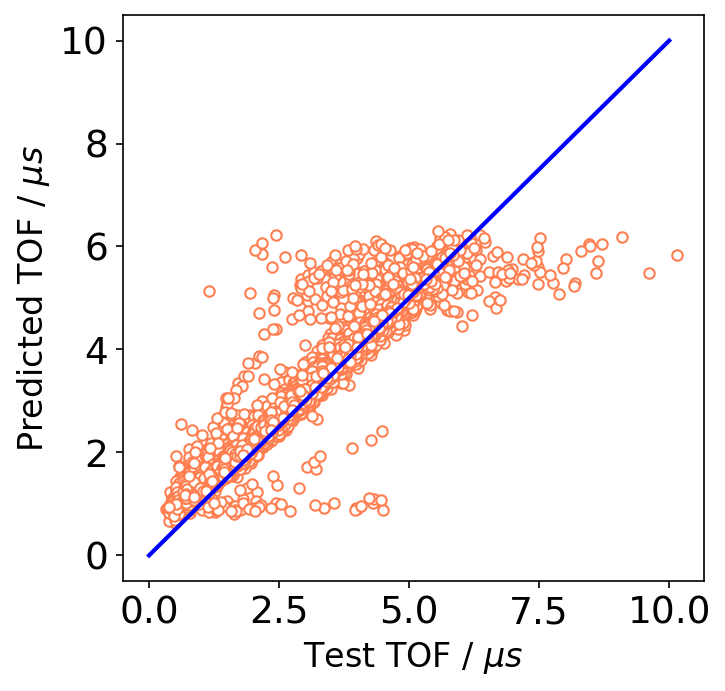

In [ ]:
from scipy.stats import gaussian_kde

plt.figure(figsize=(5,5),dpi=150)  # Figure size
mpl.rcParams.update({'font.size': 18})  # Global font size
mpl.rc('font',family='Times New Roman') # Global font style

plt.plot([0,10],[0,10],color = 'b',linewidth = 2,zorder=1)
#plt.plot([0,300],[-2,298],color = 'k',linewidth = 1,zorder=1)
#plt.plot([0,300],[2,302],color = 'k',linewidth = 1,zorder=1)
plt.scatter(np.sqrt(energy_pre),np.sqrt(energy_true),edgecolors='coral',facecolors='white',s=25,label='True Response')

#plt.xlim(150,300)
#plt.ylim(150,300)
#plt.xticks(np.arange(150, 350, 50))
#plt.yticks(np.arange(150, 350, 50))
plt.xlabel('Test TOF / $\mu s$',fontsize=16)
plt.ylabel('Predicted TOF / $\mu s$',fontsize=16)

In [ ]:
K_factor_argon = 1.398
K_factor_helium = 1.399

M_he = 4.002602     # [g/mol]
density_he = 0.1664e-3 # [g/cm^3]

M_air = 28.966     # [g/mol]
density_air = 1.205e-3 # [g/cm^3]

M_argon = 39.948      # [g/mol]
density_argon = 1.661e-3 # [g/cm^3]

Text(0, 0.5, 'Air Concentration / %')

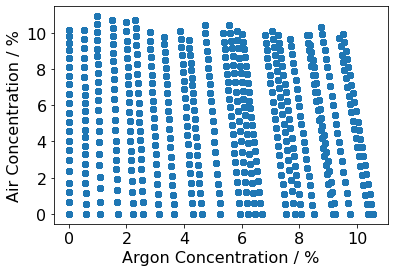

In [ ]:
plt.scatter(Excitation_set[:,-2],Excitation_set[:,-1])
plt.xlabel('Argon Concentration / %');plt.ylabel('Air Concentration / %')

In [ ]:
Amp = 800
cycles = 15
freq = 500

input = np.append(GenerateSine(Amp/1e3,freq,cycles),[0,0])
test = torch.from_numpy(input).to(torch.float32).to(device)
test_pred = branch_net(test).cpu().detach().numpy()
t_0 = FindTOF(np.transpose(test_pred.reshape(-1,1)))

Percen_Argon = np.arange(0,10,0.2)
Percen_Air = np.arange(0,10,0.2)

delta_ANN = np.zeros(0,)
delta_theory = np.zeros(0,)

for i in Percen_Air:
  for j in Percen_Argon:
    input = np.append(GenerateSine(Amp/1e3,freq,cycles),[j,i])
    test = torch.from_numpy(input).to(torch.float32).to(device)
    test_pred = branch_net(test).cpu().detach().numpy()

    delta_ANN = np.append(delta_ANN,(FindTOF(np.transpose(test_pred.reshape(-1,1)))-t_0))
    delta_theory = np.append(delta_theory,Cal_deltaTOF(j,i))
'''
for i in Percen_Argon:
  for j in Percen_Air:
    input = np.append(GenerateSine(Amp/1e3,freq,cycles),[i,j])
    test = torch.from_numpy(input).to(torch.float32).to(device)
    test_pred = branch_net(test).cpu().detach().numpy()

    delta_ANN = np.append(delta_ANN,(FindTOF(np.transpose(test_pred.reshape(-1,1)))-t_0))
    delta_theory = np.append(delta_theory,Cal_deltaTOF(i,j))
'''
Difference = delta_ANN - delta_theory

print(f'Difference = {Difference}')
print(np.mean(np.abs(Difference)))
print(np.std(np.abs(Difference)))

Difference = [ 0.         -1.53652099  3.53869778 ...  6.42599003  8.56416128
  2.90545612]
6.0881264848100125
2.809148869465136


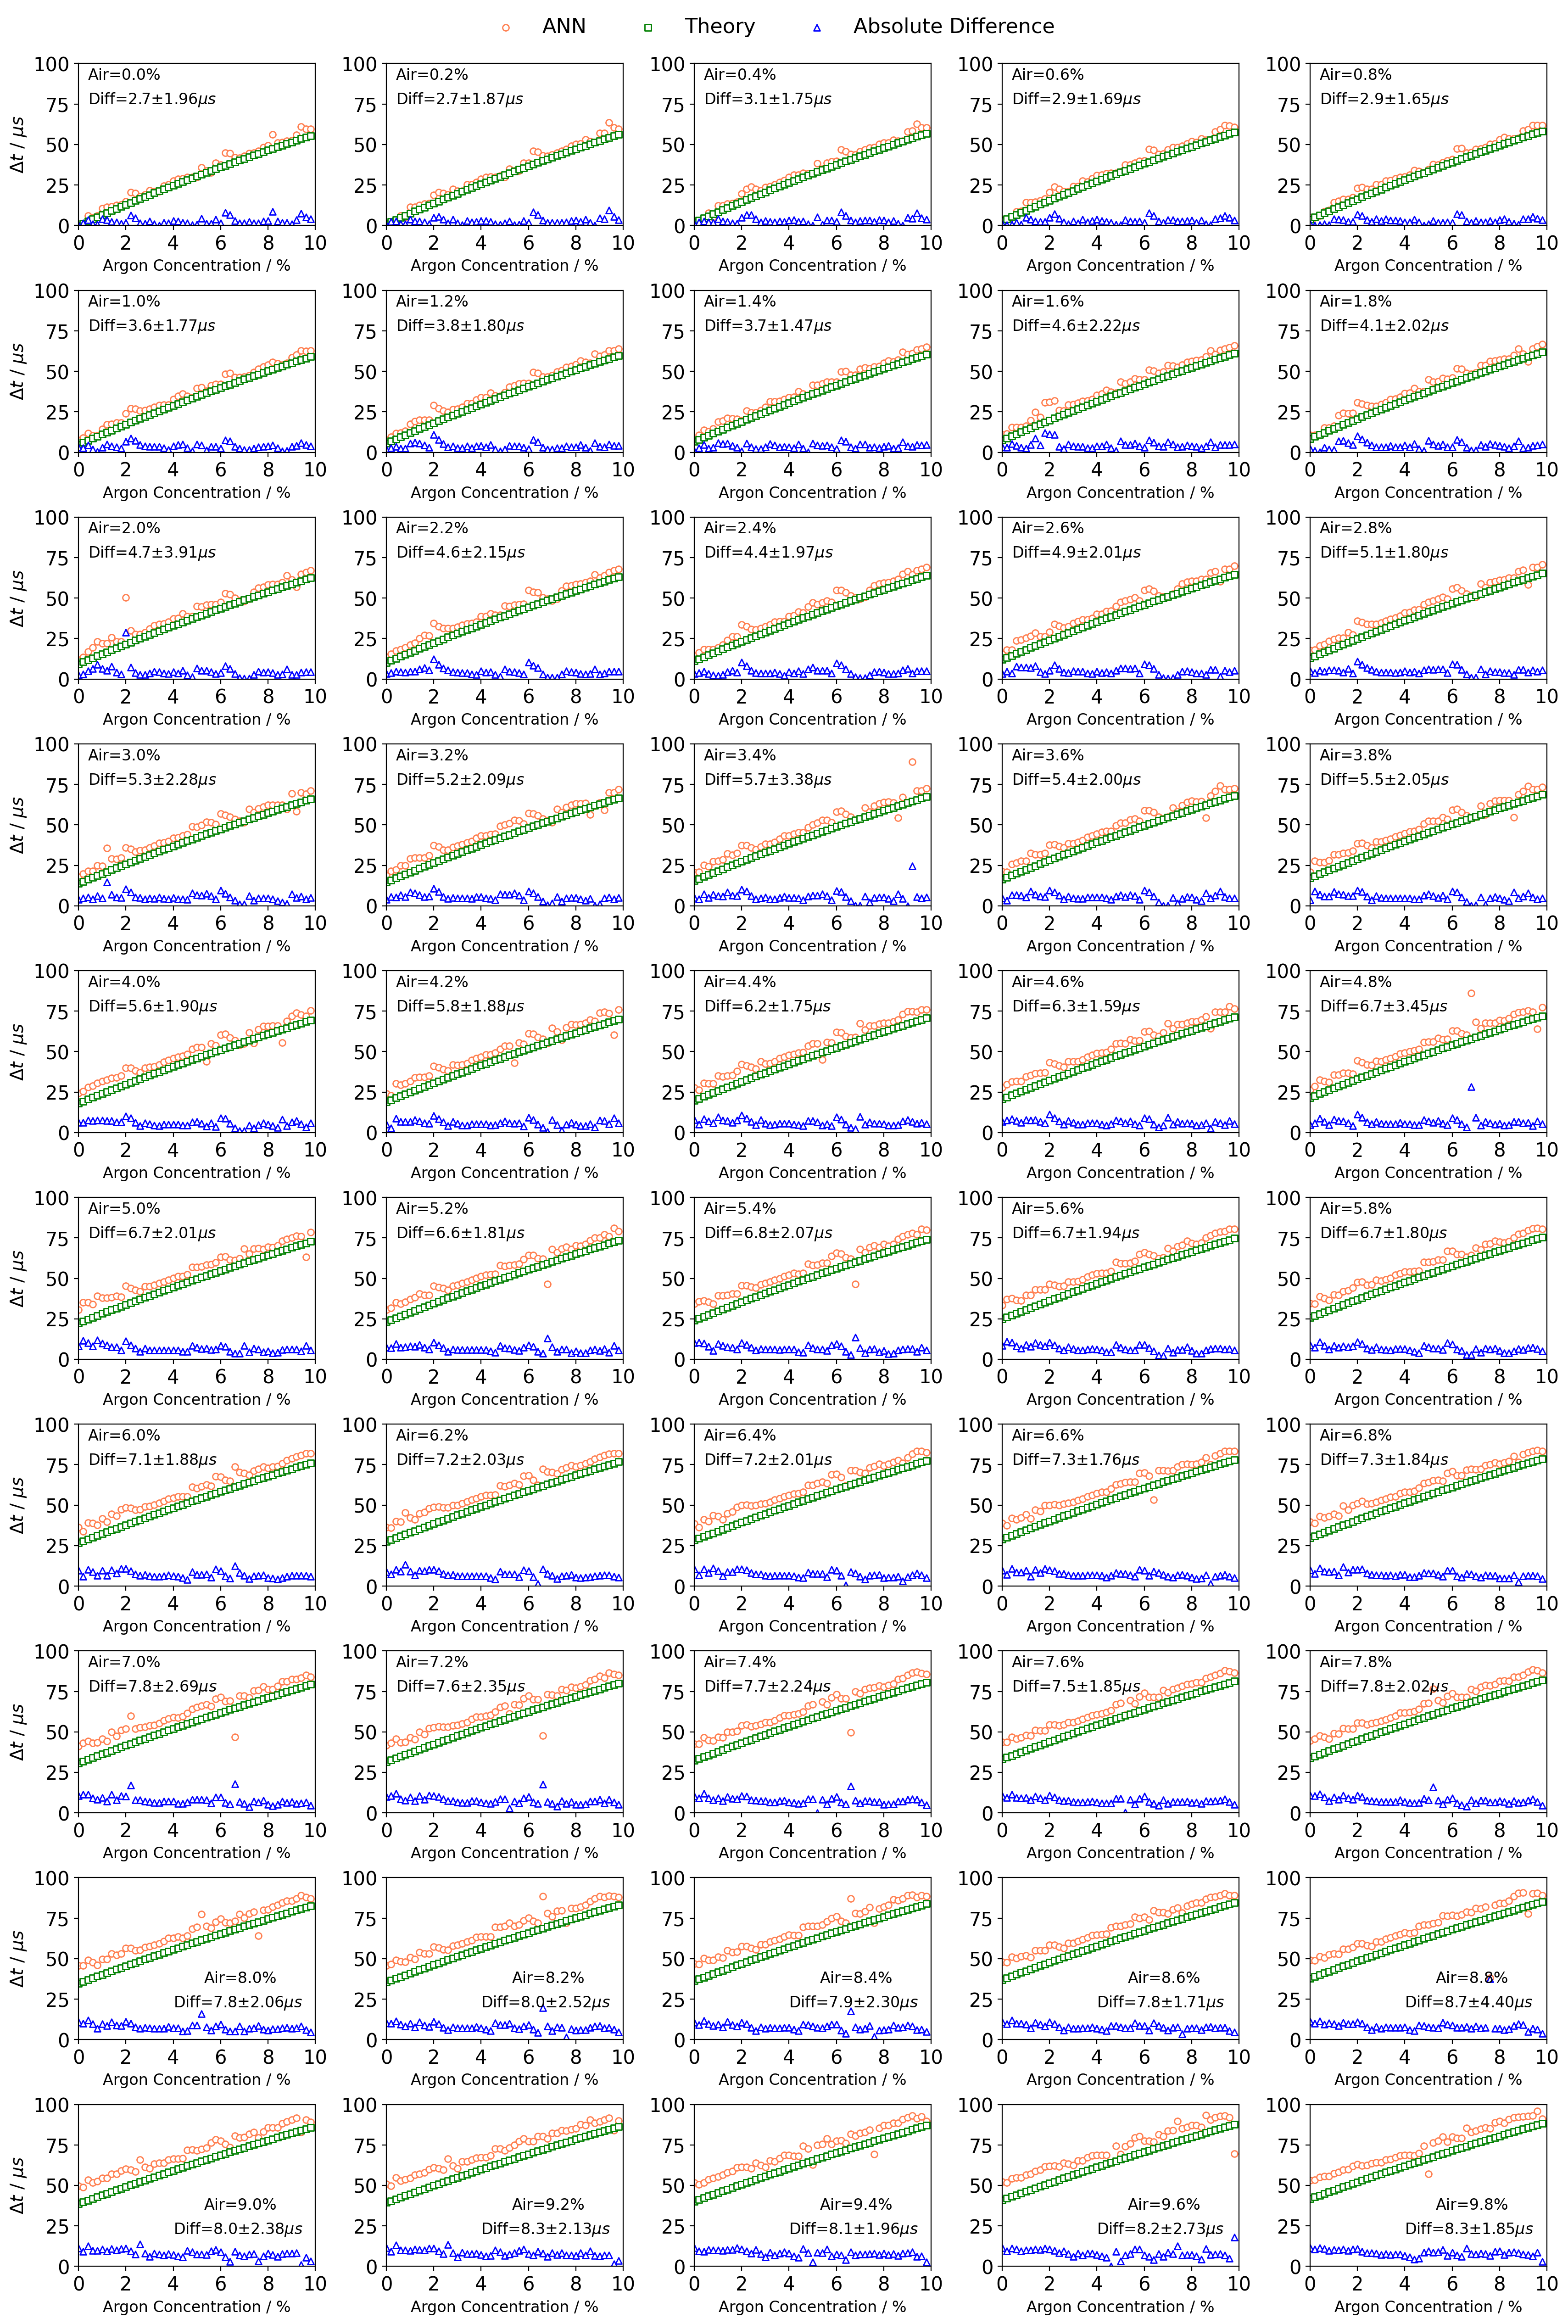

In [ ]:
num_grid = len(Percen_Argon)

nr = 10
nc = 5

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('font',**{'family':'serif','serif':['Times']})
fig, ax  = plt.subplots(nr,nc,figsize=(4*nc,3*nr),dpi=200)
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.3,hspace=0.4)
ax = ax.flatten()

for idx in range(nr*nc):

  ax[idx].scatter(Percen_Argon,delta_ANN[idx*num_grid:idx*num_grid+num_grid],label='ANN',edgecolors='coral',facecolors='white',s=25)
  ax[idx].scatter(Percen_Argon,delta_theory[idx*num_grid:idx*num_grid+num_grid],label='Theory',marker='s',edgecolors='green',facecolors='white',s=25)
  ax[idx].scatter(Percen_Argon,np.abs(Difference[idx*num_grid:idx*num_grid+num_grid]),label='Absolute Difference',marker='^',edgecolors='b',facecolors='white',s=25)

  if idx%5 == 0:
    ax[idx].set_ylabel('$\Delta t$ / $\mu s$',fontsize = 14)

  ax[idx].set_xlabel('Argon Concentration / %',fontsize = 12)
  ax[idx].set_xlim(0,10);ax[idx].set_xticks(np.arange(0, 12, 2))
  ax[idx].set_ylim(0,100);ax[idx].set_yticks(np.arange(0, 125, 25))

  if idx < 40:
    ax[idx].text(0.4, 90, f'Air={Percen_Argon[idx]:.1f}%', fontsize = 12)
    ax[idx].text(0.4, 75, f'Diff={np.mean(np.abs(Difference[idx*num_grid:idx*num_grid+num_grid])):.1f}\u00B1{np.std(np.abs(Difference[idx*num_grid:idx*num_grid+num_grid])):.2f}$\mu s$', fontsize = 12)
  else:
    ax[idx].text(5.3, 35, f'Air={Percen_Argon[idx]:.1f}%', fontsize = 12)
    ax[idx].text(4, 20, f'Diff={np.mean(np.abs(Difference[idx*num_grid:idx*num_grid+num_grid])):.1f}\u00B1{np.std(np.abs(Difference[idx*num_grid:idx*num_grid+num_grid])):.2f}$\mu s$', fontsize = 12)
plt.legend(bbox_to_anchor=(-1, 14),edgecolor='k',fontsize=16,frameon=False,ncol=3)

In [ ]:
print((y_new[0] - y_new[-1]) / y_new[0])
print((sen_theory[0] - sen_theory[-1]) / sen_theory[0])

0.3976769521361224
0.16088073474622308


Text(0.5, 0, 'Air Concentration / %')

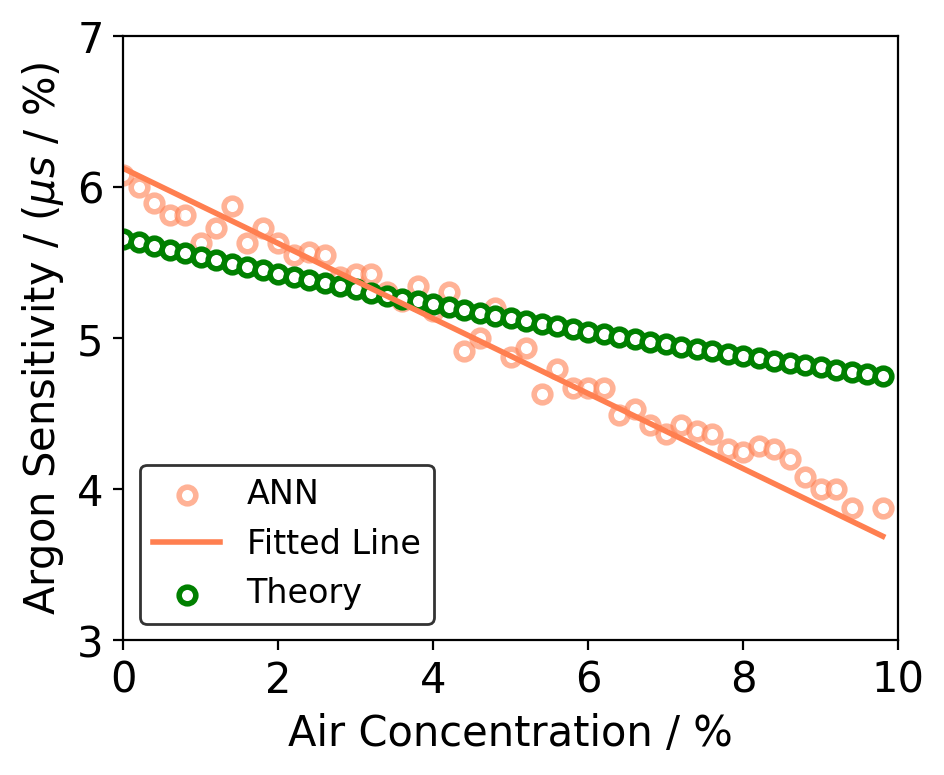

In [ ]:
plt.figure(figsize=(5,4),dpi=200)  # Figure size
mpl.rcParams.update({'font.size': 18})  # Global font size
mpl.rc('font',family='Times New Roman') # Global font style

sen_ANN = np.zeros(0,) # UNIT: micro sec / %
sen_theory = np.zeros(0,) # UNIT: micro sec / %

for idx in range(nr*nc):
  sen_ANN = np.append(sen_ANN,(delta_ANN[idx*num_grid:idx*num_grid+num_grid][-1] - delta_ANN[idx*num_grid:idx*num_grid+num_grid][0])/Percen_Air[-1])
  sen_theory = np.append(sen_theory,(delta_theory[idx*num_grid:idx*num_grid+num_grid][-1] - delta_theory[idx*num_grid:idx*num_grid+num_grid][0])/Percen_Air[-1])

z = np.polyfit(Percen_Argon, sen_ANN, 1)
f = np.poly1d(z)
y_new = f(Percen_Argon)

plt.scatter(Percen_Argon,sen_ANN,facecolors='white',linewidth =2,edgecolors='coral',alpha=0.6,label='ANN')
plt.plot(Percen_Argon,y_new,linewidth =2,color='coral',label='Fitted Line')

plt.scatter(Percen_Argon,sen_theory,facecolors='white',linewidth =2,edgecolors='green',label='Theory')

plt.xlim(0,10);plt.ylim(3,7)
plt.legend(loc='lower left',edgecolor='k',fontsize=12,frameon=True,ncol=1)

plt.ylabel('Argon Sensitivity / ($\mu s$ / %)',fontsize=15)
plt.xlabel('Air Concentration / %',fontsize=15)

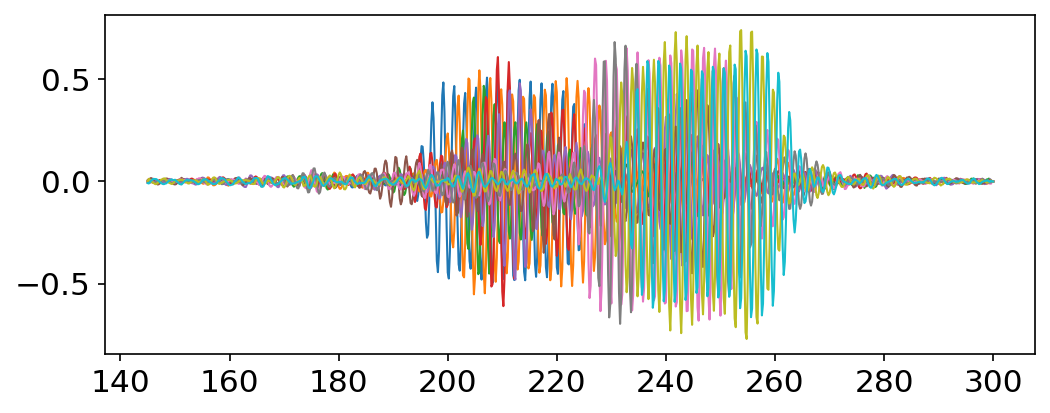

In [ ]:
plt.figure(figsize=(8,3),dpi=150)  # Figure size
mpl.rcParams.update({'font.size': 18})  # Global font size
mpl.rc('font',family='Times New Roman') # Global font style

Amp = 630
freq = 500
cycles = 15

Percen_Argon = np.arange(0,10,0.5)
Percen_Air = np.arange(0,10,0.5)

for i in np.arange(0,10,1):
  input = np.append(GenerateSine(Amp/1e3,freq,cycles),[6.8,i])
  test = torch.from_numpy(input).to(torch.float32).to(device)
  test_pred = branch_net(test).cpu().detach().numpy()
  plt.plot(Time_response*1e6,test_pred.reshape(-1,1),linewidth = 1,label='')

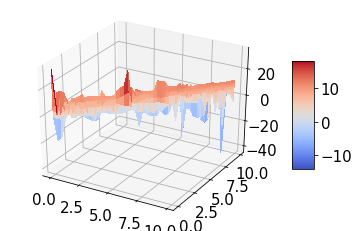

In [ ]:
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(Percen_Argon, Percen_Air, Difference.reshape((len(Percen_Argon),len(Percen_Air))),cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)

In [ ]:
Amp = 800
cycles = 15
freq = 500

input = np.append(GenerateSine(Amp/1e3,freq,cycles),[0,0])
test = torch.from_numpy(input).to(torch.float32).to(device)
test_pred = branch_net(test).cpu().detach().numpy()
t_0 = FindTOF(np.transpose(test_pred.reshape(-1,1)))

Percen_Argon = 1
Percen_Air = np.arange(0,10,0.2)

delta_ANN = np.zeros(0,)
delta_theory_high_low = np.zeros(0,)
delta_theory_low_high = np.zeros(0,)

for j in Percen_Air:
  input = np.append(GenerateSine(Amp/1e3,freq,cycles),[Percen_Argon,j])
  test = torch.from_numpy(input).to(torch.float32).to(device)
  test_pred = branch_net(test).cpu().detach().numpy()
  delta_ANN = np.append(delta_ANN,(FindTOF(np.transpose(test_pred.reshape(-1,1)))-t_0))

  delta_theory_high_low = np.append(delta_theory_high_low,Cal_deltaTOF_T(Percen_Argon,j,296,292))
  delta_theory_low_high = np.append(delta_theory_low_high,Cal_deltaTOF_T(Percen_Argon,j,292,296))

#Difference = delta_ANN - delta_theory
#print(f'Difference = {Difference}')
#print(np.mean(np.abs(Difference)))
#print(np.std(np.abs(Difference)))

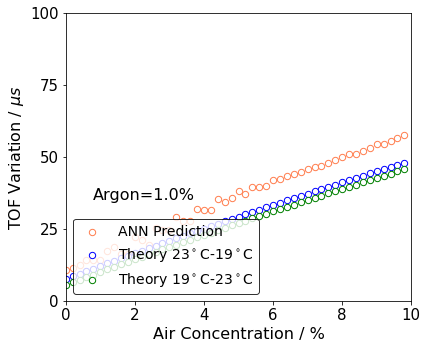

In [ ]:
num_grid = len(Percen_Air)

nr = 1
nc = 1

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('font',**{'family':'serif','serif':['Times']})
fig, ax  = plt.subplots(nr,nc,figsize=(6*nc,5*nr))
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.3,hspace=0.4)

ax.scatter(Percen_Air,delta_ANN,label='ANN Prediction',edgecolors='coral',facecolors='white',s=40)
ax.scatter(Percen_Air,delta_theory_high_low,label='Theory 23$^\circ$C-19$^\circ$C',edgecolors='b',facecolors='white',s=40)
ax.scatter(Percen_Air,delta_theory_low_high,label='Theory 19$^\circ$C-23$^\circ$C',edgecolors='green',facecolors='white',s=40)

ax.text(0.8,35, f'Argon={Percen_Argon:.1f}%', fontsize = 16)
ax.set_ylabel('TOF Variation / $\mu s$',fontsize = 16)
ax.set_xlabel('Air Concentration / %',fontsize = 16)
ax.set_xlim(0,10);ax.set_xticks(np.arange(0, 12, 2))
ax.set_ylim(0,100);ax.set_yticks(np.arange(0, 125, 25))
plt.legend(loc='lower left',edgecolor='k',fontsize=14,frameon=True,ncol=1)

In [ ]:
np.mean(delta_theory_high_low - delta_theory_low_high)

2.2662893174166374

Text(0.5, 0, 'Delta t / $\\mu s$')

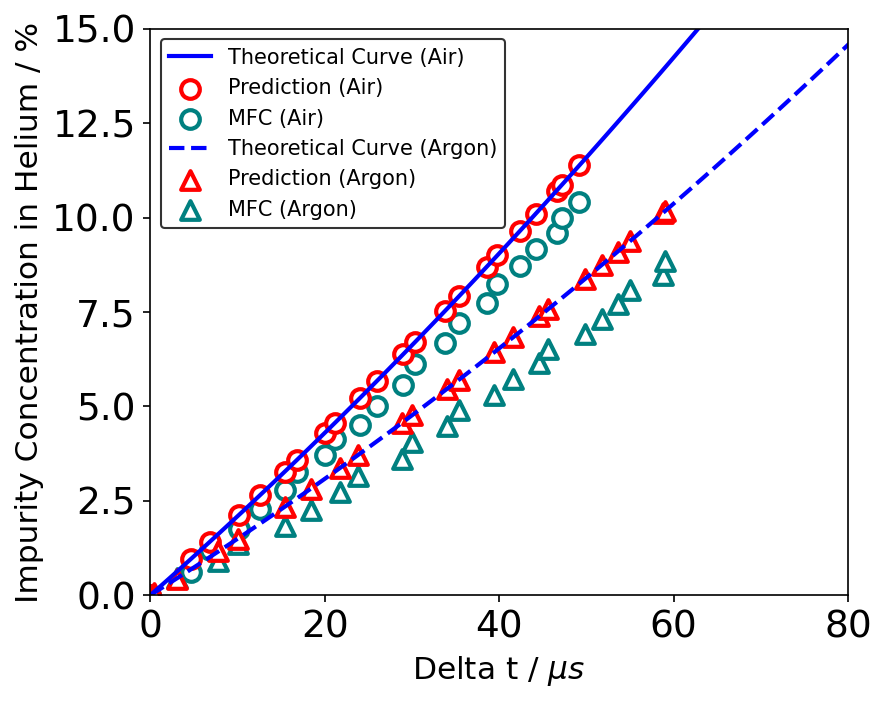

In [ ]:
plt.figure(figsize=(6,5),dpi=150)  # Figure size
mpl.rcParams.update({'font.size': 18})  # Global font size
mpl.rc('font',family='Times New Roman') # Global font style

plt.plot(delta_T,theory_percen_air,color = 'b',linewidth =2,label = 'Theoretical Curve (Air)')
plt.scatter(Delta_T_list_air,True_Percentage_air,facecolors='white',linewidth =2,edgecolors='teal',s=80,label='MFC (Air)')
plt.scatter(Delta_T_list_air,Concen_list_air,facecolors='white',linewidth =2,edgecolors='red',s=80,label='Prediction (Air)')

plt.scatter(Delta_T_list_argon,True_Percentage_argon,facecolors='white',linewidth =2,marker='^',edgecolors='teal',s=80,label='MFC (Argon)')
plt.scatter(Delta_T_list_argon,Concen_list_argon,facecolors='white',linewidth =2,marker='^',edgecolors='red',s=80,label='Prediction (Argon)')
plt.plot(delta_T,theory_perce_argon,color = 'b',linestyle = '--', linewidth =2,label = 'Theoretical Curve (Argon)')

plt.ylim(0,15);plt.xlim(0,80)

handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = [0,3,2,1,5,4]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='upper left',edgecolor='k',fontsize=10,frameon=True,ncol=1)

plt.ylabel('Impurity Concentration in Helium / %',fontsize=15)
plt.xlabel('Delta t / $\mu s$',fontsize=15)

## Noise Quantification

'\nax[2].plot(np.array(True_Percentage),percen_mean+percen_std*3,color=\'r\',linestyle=\'--\',label=r\'99.7% Confidence Region ($\\mu \\pm 3\\sigma$)\')\nax[2].plot(np.array(True_Percentage),percen_mean-percen_std*3,color=\'r\',linestyle=\'--\')\nax[2].fill_between(np.array(True_Percentage), percen_mean+percen_std*3, percen_mean-percen_std*3, facecolor="r", alpha=0.15)\nax[2].plot([0,15],[0,15],color = \'b\',linewidth = 2,zorder=0)\nax[2].scatter(np.array(True_Percentage),percen_mean,facecolors=\'none\',linewidth =2.5,edgecolors=\'r\',s=80,label=r\'Mean ($\\mu$)\')\nax[2].set_xlabel(\'True Concentration (%)\',fontsize=16);ax[2].set_ylabel(\'Predicted Concentration (%)\',fontsize=16)\nax[2].set_xlim(0,12);ax[2].set_ylim(0,12)\nax[2].set_title(\'Concentration Uncertainty\',fontsize=16)\nax[2].legend(loc=\'lower right\',edgecolor=\'k\',fontsize=10,frameon=True,ncol=1)'

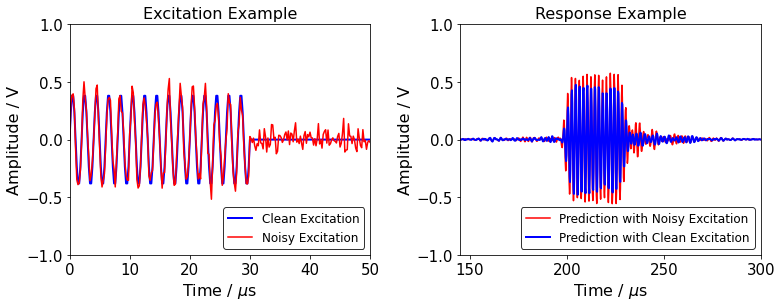

In [ ]:
percen_mean = []
percen_std = []
percen_container = []
delta_T_contain = []

argon_per = 2.4
air_per = 5.8

Noise_percen = 0.25
run = 50

input = np.append(GenerateSine(Amp/1e3,freq,cycles),[argon_per,air_per])
test = torch.from_numpy(input).to(torch.float32).to(device)
test_pure_pred = branch_net(test).cpu().detach().numpy()
TOF_2 = FindTOF(np.transpose(test_pure_pred.reshape(-1,1)))

for _ in range(run):
  noisy_input = np.append(GenerateNoisySine(Amp/1e3,freq,cycles,Noise_percen),[argon_per,air_per])
  test_noise_in = torch.from_numpy(noisy_input).to(torch.float32).to(device)
  test_noise_pred = branch_net(test_noise_in).cpu().detach().numpy()
  TOF_1 = FindTOF(np.transpose(test_noise_pred.reshape(-1,1)))
  delta_T_contain.append(TOF_1-TOF_2)

percen_matrix = np.array(delta_T_contain)
percen_mean = np.mean(percen_matrix)
percen_std = np.std(percen_matrix)
percen_matrix

nr = 1
nc = 2

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('font',**{'family':'serif','serif':['Times']})
fig, ax  = plt.subplots(nr,nc,figsize=(6*nc,4*nr))
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.3,hspace=0.4)
ax = ax.flatten()

ax[0].plot(Time_exci*1e6,test[:-2].cpu().detach().numpy(),color = 'b',linewidth = 2,label='Clean Excitation')
ax[0].plot(Time_exci*1e6,test_noise_in[:-2].cpu().detach().numpy(),color ='r',linewidth = 1.5,label='Noisy Excitation')
ax[0].set_xticks(np.arange(Time_exci[0]*1e6, Time_exci[-1]*1e6+10, 10))
ax[0].set_yticks(np.arange(-1, 1.5, .5));ax[0].set_ylim(-1,1);ax[0].set_xlim(0,50)
ax[0].set_ylabel('Amplitude / V',fontsize=16);ax[0].set_xlabel(u'Time / $\it{\u03bc}$s',fontsize=16)
ax[0].set_title('Excitation Example',fontsize=16)
ax[0].legend(loc='lower right',edgecolor='k',fontsize=12,frameon=True,ncol=1)

ax[1].plot(Time_response*1e6,test_noise_pred.reshape(-1,1),'-r',linewidth = 1.5,label='Prediction with Noisy Excitation')
ax[1].plot(Time_response*1e6,test_pure_pred.reshape(-1,1),'-b',linewidth = 2,label='Prediction with Clean Excitation')
#ax[1].set_xticks(np.arange(Time_response[0]*1e6, Time_response[-1]*1e6, 50))
ax[1].set_yticks(np.arange(-1, 1.5, .5));ax[1].set_ylim(-1,1);ax[1].set_xlim(145,300)
ax[1].set_ylabel('Amplitude / V',fontsize=16);ax[1].set_xlabel(u'Time / $\it{\u03bc}$s',fontsize=16)
ax[1].set_title('Response Example',fontsize=16)
ax[1].legend(loc='lower right',edgecolor='k',fontsize=12,frameon=True,ncol=1)
'''
ax[2].plot(np.array(True_Percentage),percen_mean+percen_std*3,color='r',linestyle='--',label=r'99.7% Confidence Region ($\mu \pm 3\sigma$)')
ax[2].plot(np.array(True_Percentage),percen_mean-percen_std*3,color='r',linestyle='--')
ax[2].fill_between(np.array(True_Percentage), percen_mean+percen_std*3, percen_mean-percen_std*3, facecolor="r", alpha=0.15)
ax[2].plot([0,15],[0,15],color = 'b',linewidth = 2,zorder=0)
ax[2].scatter(np.array(True_Percentage),percen_mean,facecolors='none',linewidth =2.5,edgecolors='r',s=80,label=r'Mean ($\mu$)')
ax[2].set_xlabel('True Concentration (%)',fontsize=16);ax[2].set_ylabel('Predicted Concentration (%)',fontsize=16)
ax[2].set_xlim(0,12);ax[2].set_ylim(0,12)
ax[2].set_title('Concentration Uncertainty',fontsize=16)
ax[2].legend(loc='lower right',edgecolor='k',fontsize=10,frameon=True,ncol=1)'''

In [ ]:
%cd /content/gdrive/MyDrive/AME508/Helium-Data/20221225_DigitalTwinData_and_Backfill_Air_NoPlates
Amp = 130
freq = 530
cycles = 7

percen_mean = []
percen_std = []
percen_container = []
test = torch.from_numpy(GenerateSine(Amp/1e3,freq,cycles)).to(torch.float32).to(device)
test_pred = branch_net(test).cpu().detach().numpy()

for idx in range(22):
  x = np.loadtxt(str(Amp)+'mVpp-'+str(freq)+'kHz-'+str(cycles)+'cycles-'+str(pre_list[idx])+'Torr.txt',dtype='float32',skiprows=5,delimiter=",")
  t0_index = np.argmin(abs(x[:,0]-145e-6))
  t_end = np.argmin(abs(x[:,0]-225e-6))
  TOF_2 = FindTOF_longwindow(np.transpose(x[t0_index:t_end,-1].reshape(-1,1)))
  TOF_1 = FindTOF(np.transpose(test_pred.reshape(-1,1)))

  percen_container.append(Cal_percentage(TOF_1,M_air,TOF_2-TOF_1,'Air').tolist()) # air
  #percen_container.append(Cal_percentage(TOF_1,M_argon,TOF_2-TOF_1,'Argon').tolist()) # argon

  #for TOF_1 in TOF_He:
    #percen_container.append(Cal_percentage(TOF_1,28.966,TOF_2-TOF_1).tolist())

#percen_matrix = np.array(percen_container).reshape((len(pre_list),run))
#percen_mean = np.mean(percen_matrix,axis=1)
#percen_std = np.std(percen_matrix,axis=1)
#percen_matrix

/content/gdrive/MyDrive/AME508/Helium-Data/20221225_DigitalTwinData_and_Backfill_Air_NoPlates


## Direct High Concen

In [ ]:
%cd /content/gdrive/MyDrive/AME508/Helium-Data/20221225_DigitalTwinData_and_Backfill_Air_NoPlates/20230105_Argon_K-Factor_WithoutPlates/DirectBackfill

total_set_high = []
impurity_set_high = []

x = np.loadtxt('Helium.csv',dtype='float32',delimiter=",")
V_He = CalVolume(x,20,'Helium')*1e3 # sccm
total_set_high.append(V_He*density_he/M_he)

y = np.loadtxt('Helium+Argon(air)20s.csv',dtype='float32',delimiter=",")
total_set_high.append(CalVolume(y,20,'Air')*K_factor_argon*density_argon/M_argon)
impurity_set_high.append(CalVolume(y,20,'Air')*K_factor_argon*density_argon/M_argon)

total_set_high = np.array(total_set_high)
total_set_high = np.cumsum(total_set_high,axis=0)

impurity_set_high = np.array(impurity_set_high)
impurity_set_high = np.pad(impurity_set_high,(1,0),'constant', constant_values=(0, ))
impurity_set_high = np.cumsum(impurity_set_high,axis=0)

True_Percentage_high = impurity_set_high / total_set_high * 100
True_Percentage_high = True_Percentage_high[1:]

percen_container_high = []
pre_list_high = [758]

for idx in range(1):
  x = np.loadtxt(str(Amp)+'mVpp-'+str(freq)+'kHz-'+str(cycles)+'cycles-'+str(pre_list_high[idx])+'Torr.txt',dtype='float32',skiprows=5,delimiter=",")
  t0_index = np.argmin(abs(x[:,0]-145e-6))
  t_end = np.argmin(abs(x[:,0]-225e-6))
  TOF_2 = FindTOF_longwindow(np.transpose(x[t0_index:t_end,-1].reshape(-1,1)))
  TOF_1 = FindTOF(np.transpose(test_pred.reshape(-1,1)))

  #percen_container_high.append(Cal_percentage(TOF_1,28.966,TOF_2-TOF_1).tolist()) # air
  percen_container_high.append(Cal_percentage(TOF_1,M_argon,TOF_2-TOF_1,'Argon').tolist()) # argon

/content/gdrive/MyDrive/AME508/Helium-Data/20221225_DigitalTwinData_and_Backfill_Air_NoPlates/20230105_Argon_K-Factor_WithoutPlates/DirectBackfill


In [ ]:
%cd /content/gdrive/MyDrive/AME508/Helium-Data/20221225_DigitalTwinData_and_Backfill_Air_NoPlates/20230105_Argon_K-Factor_WithoutPlates/DirectBackfill_Helium+Argon-All-Use-K-factor

total_set_high = []
impurity_set_high = []

x = np.loadtxt('Helium(air).csv',dtype='float32',delimiter=",")
V_He = CalVolume(x,20,'Air')*K_factor_helium # sccm
total_set_high.append(V_He*density_he/M_he)

y = np.loadtxt('Helium(air)+Argon(air)20s.csv',dtype='float32',delimiter=",")
total_set_high.append(CalVolume(y,20,'Air')*K_factor_argon*density_argon/M_argon)
impurity_set_high.append(CalVolume(y,20,'Air')*K_factor_argon*density_argon/M_argon)

total_set_high = np.array(total_set_high)
total_set_high = np.cumsum(total_set_high,axis=0)

impurity_set_high = np.array(impurity_set_high)
impurity_set_high = np.pad(impurity_set_high,(1,0),'constant', constant_values=(0, ))
impurity_set_high = np.cumsum(impurity_set_high,axis=0)

True_Percentage_high = impurity_set_high / total_set_high * 100
True_Percentage_high = True_Percentage_high[1:]

percen_container_high = []
pre_list_high = [784]

for idx in range(1):
  x = np.loadtxt(str(Amp)+'mVpp-'+str(freq)+'kHz-'+str(cycles)+'cycles-'+str(pre_list_high[idx])+'Torr.txt',dtype='float32',skiprows=5,delimiter=",")
  t0_index = np.argmin(abs(x[:,0]-145e-6))
  t_end = np.argmin(abs(x[:,0]-225e-6))
  TOF_2 = FindTOF_longwindow(np.transpose(x[t0_index:t_end,-1].reshape(-1,1)))
  TOF_1 = FindTOF(np.transpose(test_pred.reshape(-1,1)))

  #percen_container_high.append(Cal_percentage(TOF_1,28.966,TOF_2-TOF_1).tolist()) # air
  percen_container_high.append(Cal_percentage(TOF_1,M_argon,TOF_2-TOF_1,'Argon').tolist()) # argon

/content/gdrive/MyDrive/AME508/Helium-Data/20221225_DigitalTwinData_and_Backfill_Air_NoPlates/20230105_Argon_K-Factor_WithoutPlates/DirectBackfill_Helium+Argon-All-Use-K-factor


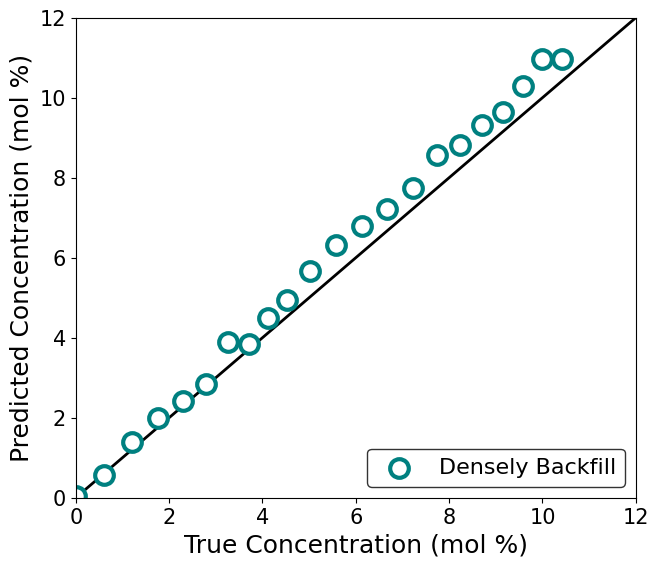

In [ ]:
nr = 1
nc = 1

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('font',**{'family':'serif','serif':['Times']})
fig, ax  = plt.subplots(nr,nc,figsize=(7*nc,6*nr))
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.3,hspace=0.4)

#plt.plot(np.array(True_Percentage),percen_mean+percen_std*3,color='r',linestyle='--',label=r'99.7% Confidence Region ($\mu \pm 3\sigma$)')
#plt.plot(np.array(True_Percentage),percen_mean-percen_std*3,color='r',linestyle='--')
#plt.fill_between(np.array(True_Percentage), percen_mean+percen_std*3, percen_mean-percen_std*3, facecolor="r", alpha=0.15)

plt.plot([0,15],[0,15],color = 'k',linewidth = 2,zorder=0)
plt.scatter(np.array(True_Percentage),percen_container,facecolors='white',linewidth =3,edgecolors='teal',s=180,label='Densely Backfill')
#plt.scatter(np.array(True_Percentage_high),percen_container_high,facecolors='white',linewidth =3,edgecolors='r',marker='*',s=250,label='Direct Backfill')

plt.xlabel('True Concentration (mol %)',fontsize=18);plt.ylabel('Predicted Concentration (mol %)',fontsize=18)
plt.xlim(0,12);plt.ylim(0,12)

plt.legend(loc='lower right',edgecolor='k',fontsize=16,frameon=True,ncol=1)

In [ ]:
True_Percentage_high

array([2.43675291])

In [ ]:
from scipy import signal

def PlotSTFT(wave,idx):
  f, t, Zxx = signal.stft(wave, 1/Ts, nperseg=128,window='hann',noverlap=120)
  t += 145e-6
  ax[idx].pcolormesh(t*1e6, f*1e-3, np.abs(Zxx), vmin=0, vmax=0.05, shading='gouraud')
  ax[idx].set_ylabel('Frequency / kHz',fontsize='16')
  ax[idx].set_xlabel(u'Time / $\it{\u03bc}$s',fontsize='16')
  ax[idx].set_ylim(0,1000)

Text(0.5, 1.0, 'Spectrum Subtraction')

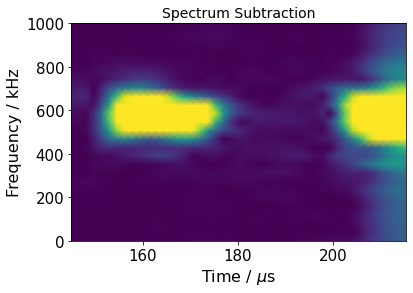

In [ ]:
test = torch.from_numpy(GenerateSine(0.84,580,5)).to(torch.float32).to(device)
test_pred = branch_net(test).cpu().detach().numpy()
f_pre, t_pre, Zxx_pre = signal.stft(test_pred, 1/Ts, nperseg=128,window='hann',noverlap=120)

x = np.loadtxt('840mVpp-580kHz-5cycles-'+str(pre_list[7])+'Torr.txt',dtype='float32',skiprows=5,delimiter=",")
t0_index = np.argmin(abs(x[:,0]-145e-6))
t_end = np.argmin(abs(x[:,0]-215e-6))
f_exp, t_exp, Zxx_exp = signal.stft(x[t0_index:t_end,-1], 1/Ts, nperseg=128,window='hann',noverlap=120)

Difference = np.abs(Zxx_pre) - np.abs(Zxx_exp)
t_pre += 145e-6
plt.pcolormesh(t_pre*1e6, f_pre*1e-3, np.abs(Difference), vmin=0, vmax=0.05, shading='gouraud')

plt.ylim(0,1000)
plt.ylabel('Frequency / kHz',fontsize='16')
plt.xlabel(u'Time / $\it{\u03bc}$s',fontsize='16')
plt.title('Spectrum Subtraction',fontsize='14')

/content/gdrive/.shortcut-targets-by-id/194AAoMald4Ypsq8mZ7vYTSA-BHCW4Wdm/AME508/Helium-Data/Training_data_pure_helium/NeverSeenData


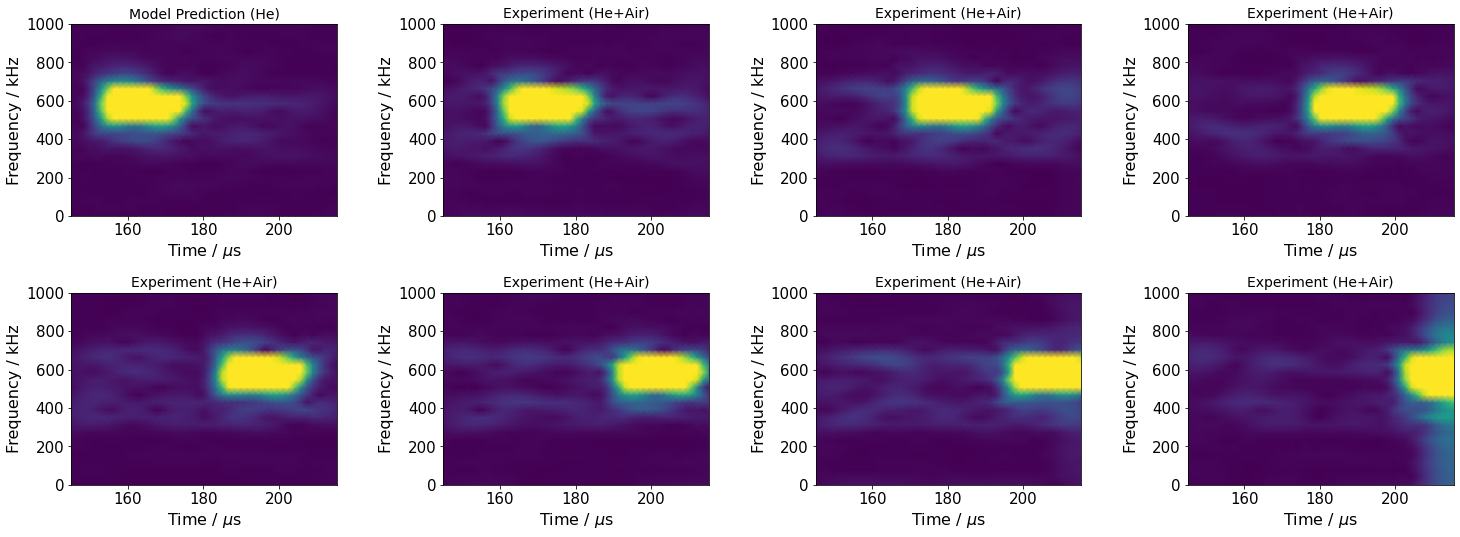

In [ ]:
%cd /content/gdrive/MyDrive/AME508/Helium-Data/Training_data_pure_helium/NeverSeenData
nr = 2
nc = 4

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('font',**{'family':'serif','serif':['Times']})
fig, ax  = plt.subplots(nr,nc,figsize=(6*nc,4*nr))
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)
ax = ax.flatten()

pre_list = [704,715,731,746,760,774,786,799]

test = torch.from_numpy(GenerateSine(0.84,580,5)).to(torch.float32).to(device)
test_pred = branch_net(test).cpu().detach().numpy()
PlotSTFT(test_pred,0)
ax[0].set_title('Model Prediction (He)',fontsize='14')

for idx in range(1,8):
  x = np.loadtxt('840mVpp-580kHz-5cycles-'+str(pre_list[idx])+'Torr.txt',dtype='float32',skiprows=5,delimiter=",")
  t0_index = np.argmin(abs(x[:,0]-145e-6))
  t_end = np.argmin(abs(x[:,0]-215e-6))
  PlotSTFT(x[t0_index:t_end,-1],idx)
  ax[idx].set_title('Experiment (He+Air)',fontsize='14')

In [74]:
wave = Response_set[680,:]
Ts = 2e-7
Threshold = 0.5

cu_list = []
lists = wave.tolist()
length = len(lists)
lists = [i**2 for i in lists]
cu_list = [sum(lists[0:x:1]) for x in range(0, length+1)]
Cum_Amp_1 =  np.array(cu_list[1:])

Cum_Amp_1_t = np.gradient(Cum_Amp_1,Ts*1e6)
Target_Amp = np.max(Cum_Amp_1_t)*Threshold
index = FindValueIndex(Cum_Amp_1_t,Target_Amp).astype(int)
TOF = next(val for x, val in enumerate(Time_response[index]) if val > 145e-6)
print(TOF*1e6)

165.8000000000005


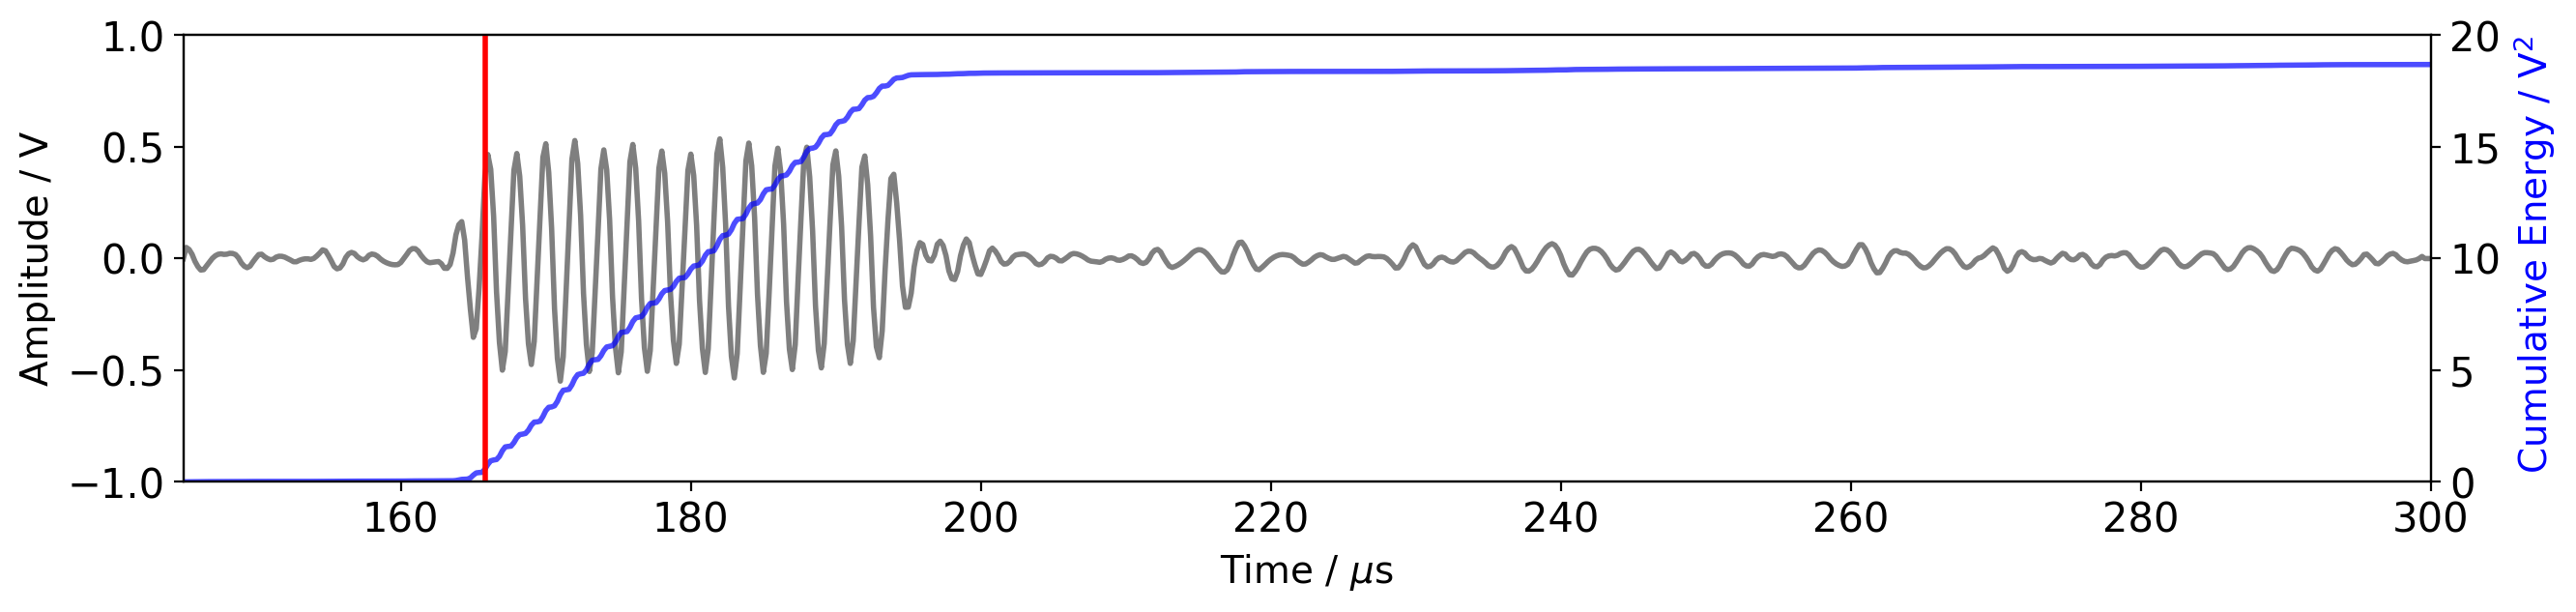

In [75]:
nr = 1
nc = 1

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('font',**{'family':'serif','serif':['Times']})
fig, ax1  = plt.subplots(nr,nc,figsize=(15*nc,3*nr),dpi=200)

t_start = 145
t_end = 300

ax2 = ax1.twinx()

ax1.plot(Time_response*1e6,wave.reshape(-1,1), 'k-',linewidth=2,alpha=0.5,label = 'Amplitude')
ax2.plot(Time_response*1e6, Cum_Amp_1, 'b',linewidth=2,alpha=0.7,label = 'Cumulative Energy')

ax1.set_xlim(t_start,t_end)
ax1.set_ylim(-1,1)
ax2.set_ylim(0,20)

ax1.set_ylabel('Amplitude / V', color='k',fontsize=14)
ax2.set_ylabel(' Cumulative Energy / V$^{2}$ ', color='b',fontsize=14)
ax1.set_xlabel(u"Time / $\it{\u03bc}$s",fontsize=14)

plt.axvline(TOF*1e6,color='r',linewidth=2)
#plt.legend(loc='lower right',edgecolor='k',fontsize='medium',frameon=False,ncol=1)

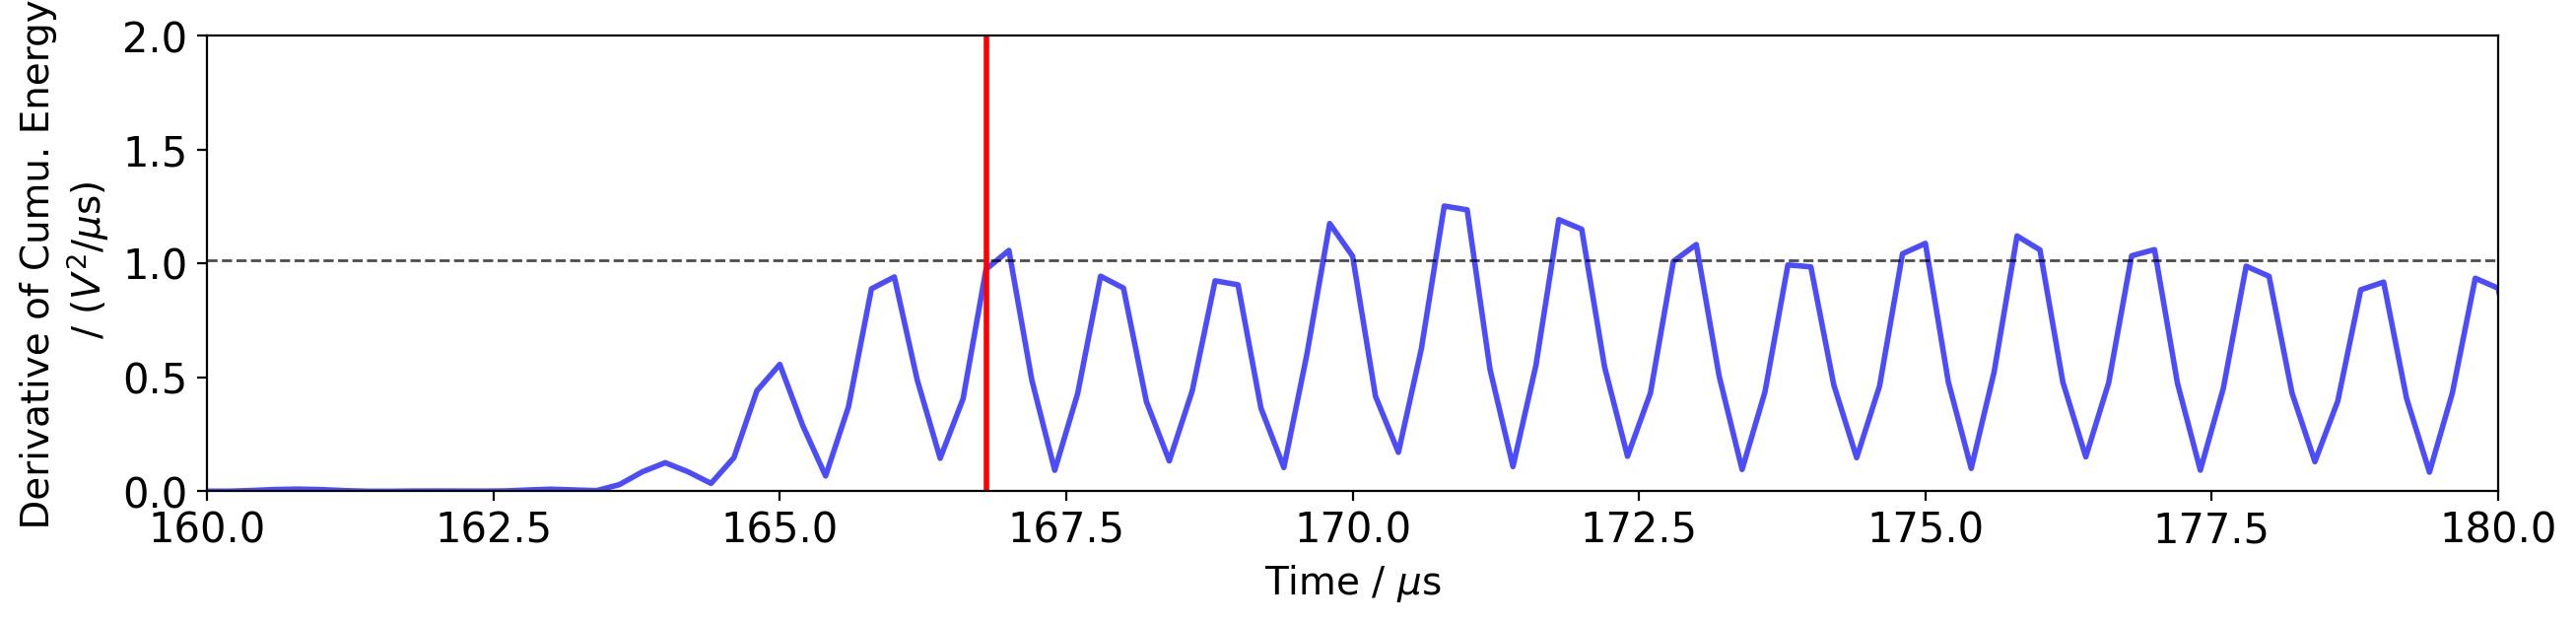

In [71]:
nr = 1
nc = 1

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('font',**{'family':'serif','serif':['Times']})
fig, ax1  = plt.subplots(nr,nc,figsize=(15*nc,3*nr),dpi=200)

ax1.plot(Time_response*1e6, Cum_Amp_1_t, 'b-',linewidth=2,alpha=0.7)
ax1.set_xlim(160,180)
ax1.set_ylim(0,2)

ax1.set_ylabel(' Derivative of Cumu. Energy \n / ($V^{2}$/$\it{\u03bc}$s) ', color='k',fontsize=14)
ax1.set_xlabel(u"Time / $\it{\u03bc}$s",fontsize=14)

plt.axhline(Target_Amp,color='k',alpha=0.7,linewidth=1,linestyle='--')
plt.axvline(TOF*1e6,color='r',linewidth=2)